## CHIMERE AOD post-processor

In [1]:
# Author: farouk.lemmouchi@lisa.ipsl.fr
# This code along with the data are a demo to showcase the CHIMERE bias correction models capability
# developped and described in the paper

# "Machine learning-based improvement of aerosol optical depth from CHIMERE simulations using MODIS satellite observations"
# F. Lemmouchi ¹, J. Cuesta ¹, M. Lachatre ², J. Brajard ³, A. Coman ¹, M. Beekmann ¹, C. Derognat ²
# ¹ LISA, UMR 7583 CNRS, Université Paris-Est Créteil
# ² ARIA Technologies, Boulogne-Billancourt, France
# ³ Nansen Environmental and Remote Sensing Center (NERSC), Bergen, Norway

# THE SOFTWARE IS FOR R&D PURPOSES AND PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED,
# INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR
# PURPOSE AND NONINFRINGEMENT.

In [2]:
import tensorflow as tf; print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#import cuml
import matplotlib.pyplot as plt

plt.style.use("ggplot")

import warnings;  warnings.filterwarnings('ignore')
seed = 10
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import normalize,  minmax_scale
#from sklearn.cluster import KMeans
#from sklearn.decomposition import PCA, SparsePCA
from aeros5py.utils import count_days
import gc, random, datetime    
from time import time 
#from random import shuffle
#from sklearn.neighbors import NearestNeighbors
#from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from functions import *
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
import scipy
import yaml, os

test_n  = 4 # for Lemmouchi et al., 2023 Remote Sensing


Num GPUs Available:  0


## Parameters

In [3]:
import cartopy.crs as ccrs
import pickle
test_n = 4

In [4]:
variables = dict()
figsize=(14,7)
seed = 10
wv = "550.0"
projection=ccrs.PlateCarree()
variables["var_2d_modis"] = ["lon", "lat", "AOD_550_Dark_Target_Deep_Blue_Combined"]

#variables["var_2d_ch"] = [ "lon", "lat", "albedo", "copc", "lspc", "pblh", "sshf", "swrd", "tem2", "topc", "u10m", "usta", "v10m", "ws10m", "wsta", "slhf", "soim", "sreh", "aerr", "atte"] 
#variables["var_2d_ch"] = ["hght", "albedo", "usta", "wsta"] # deepencoder & random forest GOOOOOOOD
#variables["var_2d_ch"] = ["albedo","swrd","topc","soim","sreh", "wsta","usta","hght","slhf","sshf"] #"lspc", "copc", #,"atte"] # full
#variables["var_2d_ch"] = ["albedo","swrd","soim","sreh", "hght"] #"lspc", "copc", #,"atte"] # full 69
#variables["var_2d_ch"] = ["lspc", "copc", #,"atte"] # full

# Note: aod_550 should take always the first rank if used.
#variables["var_2d_ch"] = ["albedo","swrd","sreh", "slhf","sshf"] #"hght","lspc", "copc", #,"atte"] # full
variables["var_2d_ch"] = ["albedo","swrd","soim","sreh", "hght","slhf","sshf"] #"lspc", "copc", #,"atte"] # full

# bad variables : albedo
#variables["var_2d_ch"] = ["lon", "lat", "optdaero_550.0", "hght", "albedo","tem2","u10m","v10m"] # deepencoder & random forest

#variables["var_2d_ch"] = ['lon', 'lat', 'optdaero_550.0', 'pblh', 'usta', 'wsta', 'tem2', 'v10m', 'u10m', 'ws10m']
#variables["var_3d_ch"] = ['PM10', 'PM25', 'temp', 'winm', 'winw', 'pres']
#variables["var_3d_ch"] = ['PM10', 'temp', 'pres'] #'winm', 'winw', 'pres']

#variables["var_3d_ch"] = [ "pres", "rain", "relh", "snow", "sphu", "temp", "thlay", "winm", "winz", "winw",
#                      "PM25bio", "PM25ant", "PM25", "O3", "NO2", "NO", "PAN", "HNO3", "H2O2", "H2SO4",
#                      "HONO_CHEM", "HONO_AER", "HONO_SURF", "HONO_ANT", "HONO_FIRE", "SO2", "CO", "OH", "CH4", "C2H6", "NC4H10",
#                      "C2H4", "C3H6", "OXYL", "C5H8", "HCHO", "CH3CHO", "GLYOX", "MGLYOX", "CH3COE", "NH3", "APINEN", "BPINEN", "LIMONE", "TERPEN", "OCIMEN",
#                      "HUMULE", "TOL", "TMB", "AnA1D", "AnBmP", "BiA1D", "BiBmP", "ISOPA1", "PPMAQ", "H2SO4AQ", "HNO3AQ", "NH3AQ", "AnA1DAQ", "AnBmPAQ",
#                      "BiA1DAQ", "BiBmPAQ", "ISOPA1AQ", "HCL", "HCLAQ", "NAAQ", "DUSTAQ", "OCARAQ", "BCARAQ", "DMS", "DMSO",
#                      "MSA", "TOTPAN", "NOX", "OX", "HOX", "NOY", "ROOH", "HCNM", "pBCAR", "pDUST", "pNA", "pOCAR", "pPPM", "pAnA1D", "pAnBmP", "pBiA1D",
#                      "pBiBmP", "pISOPA1", "pH2SO4", "pHCL", "pHNO3", "pNH3", "pWATER", "PM25", "PM10", "PM25", "PM10bio", "PM10ant", "chem_regime", "airm",
#                      "CloudpH", "AeropH", "kzzz", "cliq", "cice", "dpeu", "dpdu", "dpdd", "flxu", "flxd", "jO3", "jNO2"  ]
#variables["var_3d_ch"] = ["pBCAR","pOCAR", "pDUST", "PM10", "PM25", "O3", "NO2", "temp", "relh", "pres", "winm", "winw", "winz"] #deepencoder & randomforest GOOOOOOOD
#variables["var_3d_ch"] = ["PM10","PM25","pDUST","pBCAR","CO","NO2","O3","pres","temp","relh","winm","winz","winw"] # presentation Reunion 1

#variables["var_3d_ch"] = ["winz","winm","winw","pres","airm", "relh","temp","sphu","O3","SO2","CO","OH","CH4","NH3","TOL","NOX","HOX","NOY","ROOH","HCNM","pDUST","pOCAR","pSALT","pH2SO4","pHNO3","pNH3","pWATER"] #full

#variables["var_3d_ch"] = ["temp", "pHNO3", "sphu", "pH2SO4", "OH"] #minimal

variables["var_3d_ch"] =  ["pres","relh","ROOH","HCNM","pSALT","pH2SO4","pHNO3","pNH3","pWATER","pDUST","pOCAR","sphu", "O3","SO2","CO","OH","NH3","TOL","NOX","NOY",] # Lemmouchi et al. 2023 ?

##########variables["var_3d_ch"] = ["PM10", "PM25", "pDUST","pOCAR","pWATER","pSALT","pres","relh","ROOH","HCNM","pH2SO4","pHNO3","pNH3","sphu","O3","SO2","CO","OH","NH3","TOL","NOX","NOY"]
#variables["var_3d_ch"] = ["PM10", "PM25", "pDUST","pOCAR","pWATER", "winz", "winm", "winw"]

# columns = [ "lon", "lat"] + variables["var_2d_ch"] 
# for v3d in variables["var_3d_ch"] :
#     for i in range(4) :
#         columns.append(v3d + str(i))

#variables["var_3d_ch"] = ["O3","pDUST","pOCAR","pres"] ,
#variables["var_3d_ch"] = ["PM10","relh", "pres"] #deepencoder & randomforest  f"",
#variables["var_3d_ch"] = ["PM10", "PM25", "pBCAR", "pOCAR", "O3", "NO2", "temp", "relh", "pres", "winm", "winw", "winz"] #deepencoder & randomforest 
#variables["var_3d_ch"] = [] #"PM10", "PM25"] #"PM10"] #pBCAR","pOCAR", "pDUST", "PM10", "PM25", "O3", "NO2", "temp", "relh", "pres", "winm", "winw", "winz"] #, ]

#variables["var_3d_ch"] = []

which_inst = "AQUA"
config = {
    "wv" : "550.0", #200 300 400 600 999
    "aod_threshold" : None, # (0,0.6),  #(-10., 70),
    "res" : 0.45,
    "hour" : '13',
    "which_inst" : which_inst,
    "region" : "AFRICA",
    "var_3d_ch" : variables["var_3d_ch"],
    "var_2d_ch" : variables["var_2d_ch"],
    "var_2d_modis" : variables["var_2d_modis"],
    "version" : "v23",
    "test_n": test_n,
}

#print(columns)

## Training dates selection

In [5]:
# 1/3 first days
train_dates = [] #count_days('20210510','2020531','%Y%m%d')
for month in range(1,13,1) :
    train_dates = train_dates + count_days(f'2021{str.zfill(str(month),2)}01',f'2021{str.zfill(str(month),2)}20','%Y%m%d')

tmp_dates = count_days('20210101','20211231','%Y%m%d')

for d in train_dates + ["20210923", "20210925", "20210924"] : #, "20211014"] # no modis on 23-25 Sep 2021
    tmp_dates.remove(d)
valid_dates = tmp_dates

all_dates = count_days('20210101','20211231','%Y%m%d')
for d in ["20210923", "20210925", "20210924"] : #, "20211014"] # no modis on 23-25 Sep 2021
    all_dates.remove(d)
    
print(len(train_dates), len(valid_dates), len(all_dates) )
config['train_dates'] = train_dates
config['valid_dates'] = valid_dates


Counting days...from 20210101 to 20210120
Counting days...from 20210201 to 20210220
Counting days...from 20210301 to 20210320
Counting days...from 20210401 to 20210420
Counting days...from 20210501 to 20210520
Counting days...from 20210601 to 20210620
Counting days...from 20210701 to 20210720
Counting days...from 20210801 to 20210820
Counting days...from 20210901 to 20210920
Counting days...from 20211001 to 20211020
Counting days...from 20211101 to 20211120
Counting days...from 20211201 to 20211220
Counting days...from 20210101 to 20211231
Counting days...from 20210101 to 20211231
240 122 362


In [6]:
output_path0 = f'./models/{config["region"]}/'
if not os.path.exists(output_path0) : os.mkdir(output_path0)

# SAVE CONFIG
f = open(f'{output_path0}/config_{config["test_n"]}.yaml', 'w+')
yaml.dump(config, f, allow_unicode=True)

# # LOAD CONFIG
# with open(f"config_{test_n}.yaml") as f :
#     config = yaml.load(f)

## Input/Output setup

#### Extracting

In [7]:
input_layer_train, reference_layer_train = load_input_output2(date=train_dates[0], common_na_mask=True, plot_corr=False,
                                                do_modis=True, do_chimere=True, **config) # do not remove this line
input_layer_train ['date'] = train_dates[0]

# The train days
for date in train_dates[1:] :
  print(date, end=', ')
  #try :
  inp, out = load_input_output2(date=date, **config, common_na_mask=True,
                                                do_modis=True, do_chimere=True) # do not remove this line
  inp['date'] = date
  input_layer_train = input_layer_train.append(inp)
  reference_layer_train = reference_layer_train.append(out)
  #except :
print("\nInput layer train", input_layer_train.shape)
print("\nReference layer train", reference_layer_train.shape)

20210102, 20210103, 20210104, 20210105, 20210106, 20210107, 20210108, 20210109, 20210110, 20210111, 20210112, 20210113, 20210114, 20210115, 20210116, 20210117, 20210118, 20210119, 20210120, 20210201, 20210202, 20210203, 20210204, 20210205, 20210206, 20210207, 20210208, 20210209, 20210210, 20210211, 20210212, 20210213, 20210214, 20210215, 20210216, 20210217, 20210218, 20210219, 20210220, 20210301, 20210302, 20210303, 20210304, 20210305, 20210306, 20210307, 20210308, 20210309, 20210310, 20210311, 20210312, 20210313, 20210314, 20210315, 20210316, 20210317, 20210318, 20210319, 20210320, 20210401, 20210402, 20210403, 20210404, 20210405, 20210406, 20210407, 20210408, 20210409, 20210410, 20210411, 20210412, 20210413, 20210414, 20210415, 20210416, 20210417, 20210418, 20210419, 20210420, 20210501, 20210502, 20210503, 20210504, 20210505, 20210506, 20210507, 20210508, 20210509, 20210510, 20210511, 20210512, 20210513, 20210514, 20210515, 20210516, 20210517, 20210518, 20210519, 20210520, 20210601, 

In [8]:
# Create dataset with both CHIMERE and MODIS common data for train dates

dataset = input_layer_train
dataset.insert(input_layer_train.shape[1], value=reference_layer_train.iloc[:,2].values, column="MODIS")

print("\nCoincident CHIMERE/MODIS data")
print("\nInput layer train", input_layer_train.shape)
print("\nReference layer train", reference_layer_train.shape)
print("\n")


Coincident CHIMERE/MODIS data

Input layer train (1702302, 92)

Reference layer train (1702302, 3)




In [9]:
# The rest of the days (CHIMERE data without coincidence with MODIS)


for date in train_dates[:] :
  print(date, end=', ')
  #try :
  inp, out = load_input_output2(date=date, **config, common_na_mask=False,
                                                do_modis=True, do_chimere=True) # do not remove this line
  inp['date'] = date
  input_layer_train = input_layer_train.append(inp)
  reference_layer = reference_layer_train.append(out)
  #except :

print("\n All training dates & Including CHIMERE only pixels => dataset ")
print("\nInput layer train", input_layer_train.shape)
print("\nReference layer train", reference_layer_train.shape)
print("\n")


20210101, 20210102, 20210103, 20210104, 20210105, 20210106, 20210107, 20210108, 20210109, 20210110, 20210111, 20210112, 20210113, 20210114, 20210115, 20210116, 20210117, 20210118, 20210119, 20210120, 20210201, 20210202, 20210203, 20210204, 20210205, 20210206, 20210207, 20210208, 20210209, 20210210, 20210211, 20210212, 20210213, 20210214, 20210215, 20210216, 20210217, 20210218, 20210219, 20210220, 20210301, 20210302, 20210303, 20210304, 20210305, 20210306, 20210307, 20210308, 20210309, 20210310, 20210311, 20210312, 20210313, 20210314, 20210315, 20210316, 20210317, 20210318, 20210319, 20210320, 20210401, 20210402, 20210403, 20210404, 20210405, 20210406, 20210407, 20210408, 20210409, 20210410, 20210411, 20210412, 20210413, 20210414, 20210415, 20210416, 20210417, 20210418, 20210419, 20210420, 20210501, 20210502, 20210503, 20210504, 20210505, 20210506, 20210507, 20210508, 20210509, 20210510, 20210511, 20210512, 20210513, 20210514, 20210515, 20210516, 20210517, 20210518, 20210519, 20210520, 

In [10]:
# The validation days
input_layer_valid, reference_layer_valid = load_input_output2(date=valid_dates[0], common_na_mask=True, plot_corr=False,
                                                do_modis=True, do_chimere=True, **config) # do not remove this line
input_layer_valid['date'] = valid_dates[0]

for date in valid_dates[1:] :
  print(date, end=', ')
  #try :
  inp, out = load_input_output2(date=date, **config, common_na_mask=True,
                                                do_modis=True, do_chimere=True) # do not remove this line
  inp['date'] = date
  input_layer_valid = input_layer_valid.append(inp)
  reference_layer_valid = reference_layer_valid.append(out)

dataset_valid = input_layer_valid
dataset_valid.insert(input_layer_valid.shape[1], value=reference_layer_valid.iloc[:,2].values, column="MODIS")

#date1 = '20210930'
#a = input_layer_valid[input_layer_valid['date'] == date1]
#print(a)
#print(a.shape)

for date in valid_dates[:] :
  print(date, end=', ')
  #try :
  inp, out = load_input_output2(date=date, **config, common_na_mask=False,
                                                do_modis=True, do_chimere=True) # do not remove this line
  inp['date'] = date
  input_layer_valid = input_layer_valid.append(inp)
  reference_layer_valid = reference_layer_valid.append(out)

print("\nIncluding CHIMERE only pixels & Validation dates => dataset_valid ")
print("\nInput layer valid ", input_layer_valid.shape)
print("\nReference layer valid ", reference_layer_valid.shape)
print("\n")

dataset_valid = input_layer_valid

20210122, 20210123, 20210124, 20210125, 20210126, 20210127, 20210128, 20210129, 20210130, 20210131, 20210221, 20210222, 20210223, 20210224, 20210225, 20210226, 20210227, 20210228, 20210321, 20210322, 20210323, 20210324, 20210325, 20210326, 20210327, 20210328, 20210329, 20210330, 20210331, 20210421, 20210422, 20210423, 20210424, 20210425, 20210426, 20210427, 20210428, 20210429, 20210430, 20210521, 20210522, 20210523, 20210524, 20210525, 20210526, 20210527, 20210528, 20210529, 20210530, 20210531, 20210621, 20210622, 20210623, 20210624, 20210625, 20210626, 20210627, 20210628, 20210629, 20210630, 20210721, 20210722, 20210723, 20210724, 20210725, 20210726, 20210727, 20210728, 20210729, 20210730, 20210731, 20210821, 20210822, 20210823, 20210824, 20210825, 20210826, 20210827, 20210828, 20210829, 20210830, 20210831, 20210921, 20210922, 20210926, 20210927, 20210928, 20210929, 20210930, 20211021, 20211022, 20211023, 20211024, 20211025, 20211026, 20211027, 20211028, 20211029, 20211030, 20211031, 

#### Saving Input_layer and reference_layer

In [11]:
import pickle

output_path0 = f"./models/{config['region']}/"
if not os.path.exists(output_path0) : os.mkdir(output_path0)

pickle.dump(input_layer_train, open(f"./models/{config['region']}/input_layer_train_{config['test_n']}.pkl", 'wb'))
pickle.dump(reference_layer_train, open(f"./models/{config['region']}/reference_layer_train_{config['test_n']}.pkl", 'wb'))

pickle.dump(input_layer_valid, open(f"./models/{config['region']}/input_layer_valid_{config['test_n']}.pkl", 'wb'))
pickle.dump(reference_layer_valid, open(f"./models/{config['region']}/reference_layer_valid_{config['test_n']}.pkl", 'wb'))

#input_layer_train = pickle.load(open(f"./models/{config['region']}/input_layer_train_{config['test_n']}.pkl", 'rb'))
#reference_layer_train = pickle.load(open(f"./models/{config['region']}/reference_layer_train_{config['test_n']}.pkl", 'rb'))

In [12]:
# Removing the equator region coz of low fire emissions issue
dataset = dataset[dataset.lat>10]
#### llllllllllllllllllllll Remove lon lat lllllllllllllllllll
dataset = dataset.iloc[:,2:]


In [13]:
# #Remove MODIS pixels that are AOD limited to 3.5
# idx0 = (dataset.MODIS < 3.45) | (dataset.MODIS > 3.51)
# plt.scatter(dataset.aod_550[idx0], dataset.MODIS[idx0], 1, c='k')
# plt.show()
# plt.scatter(input_layer[:,0], reference_layer, 2)
#dataset = dataset[idx0]

### Train/test data splitting

In [14]:
dataset = dataset.sample(frac=1, random_state=3214)
halfsiz = int(dataset.index.size/2)

#x_train, y_train = dataset.iloc[:halfsiz,:-1].values, dataset.iloc[:halfsiz,-1].values.reshape(-1,1)
#x_test, y_test = dataset.iloc[halfsiz:,:-1].values, dataset.iloc[halfsiz:,-1].values.reshape(-1,1)
x_train, y_train = dataset.iloc[:halfsiz,:-2].values, dataset.iloc[:halfsiz,-1].values.reshape(-1,1) # -2 for withdrawing the date & MODIS by Juan
x_test, y_test = dataset.iloc[halfsiz:,:-2].values, dataset.iloc[halfsiz:,-1].values.reshape(-1,1) # -2 for withdrawing the date & MODIS by Juan

#from sklearn.model_selection import train_test_split
#x_train, x_test = train_test_split(input_layer, random_state=seed, shuffle=True)
#y_train, y_test = train_test_split(reference_layer, random_state=seed, shuffle=True)

input_layer = dataset.iloc[:,:-1].values; reference_layer = dataset.iloc[:,-1].values.reshape(-1,1)

In [15]:
# Saving DTrain & DTest by Juan
DTrain = dataset.iloc[:halfsiz,:]
DTest = dataset.iloc[halfsiz:,:]

pickle.dump(DTrain, open(f"./models/{config['region']}/DTrain_{config['test_n']}.pkl", 'wb'))
pickle.dump(DTest, open(f"./models/{config['region']}/DTest_{config['test_n']}.pkl", 'wb'))


## Random forest 

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [17]:
# Thanks to this post https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
model_type = "random_forest"
# model selection
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 50)]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [] #[int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2] #, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf =  [1] #, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {
    'n_estimators': n_estimators,
    'max_features': ['sqrt', 'log2'],
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

# Create a based model
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=random_grid,
                               n_iter=100,
                               cv=3,
                               verbose=1,
                               random_state=seed,
                               n_jobs=2) # n_jobs=-1 for all available processors

#rf_random.fit(x_train[:100,:], y_train[:100].flatten()) # first 100 elements - small test
#rf_random.fit(input_layer, reference_layer.flatten()) # full run

rf_random.fit(x_train[:10000,:], y_train[:10000].flatten()) # only 10 000 pixels

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=2,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1],
                                        'min_samples_split': [2],
                                        'n_estimators': [100, 102, 104, 106,
                                                         108, 110, 112, 114,
                                                         116, 118, 120, 122,
                                                         124, 126, 128, 130,
                                                         132, 134, 136, 138,
                                                         140, 142, 144, 146,
                                                         148, 151, 153, 155,
                                                         157, 159, ...]},
                   random_state=10, verbose=1)

In [18]:
print(rf_random.best_estimator_)

RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=173)


In [19]:
#del grid_search, rf

In [20]:
# Grid search CPU
model_type = "random_forest"

from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False, True],
    'random_state':[seed],
    'max_features': ['sqrt'], #, 'log2'],
    'min_samples_leaf':[2], # , 4, 6],
    'min_samples_split':[2], #, 4, 6],
    'n_estimators': [100] #list(np.arange(20) ) #, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                  cv=2, n_jobs=2, verbose=3) # n_jobs=-1 for all available processors
start= time()
#grid_search.fit(input_layer, reference_layer.flatten()) # full dataset / too long
grid_search.fit(x_train[:10000,:] , y_train[:10000].flatten()) # only 10 000 pixels

end= time()
cost = np.round( (end - start)/60 , 2)
print(f"FT finished in : {cost} minutes")

Fitting 2 folds for each of 2 candidates, totalling 4 fits
FT finished in : 0.33 minutes


In [21]:
#rf = cuml.RandomForestRegressor()

In [22]:
## Grid search GPU
#model_type = "random_forest"

#from cuml.model_selection import GridSearchCV
## Create the parameter grid based on the results of random search
#param_grid = dict(                 random_state=[seed], 
#                                   #n_streams=[],
#                                   #split_criterion=split_criterion, 
#
#                                   max_features=['auto'], n_bins=[64, 128],
#                                   min_samples_leaf=[2, 4, 6],
#                                   min_samples_split=[2, 4, 6],
#                                   n_estimators=[100])
## Create a based model
#rf = cuml.RandomForestRegressor()
## Instantiate the grid search model
#grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_mean_squared_error',
#                          cv=2, verbose=2)
#start= time()
##grid_search.fit(np.array(input_layer, dtype=np.float32), np.array(reference_layer,dtype=np.float32))
#grid_search.fit(input_layer, reference_layer)
#end = time()
#
#cost = np.round( (end - start)/60 , 2)
#print(f"FT finished in : {cost} minutes")

In [23]:
model0 = grid_search.best_estimator_

In [24]:
model = grid_search.best_estimator_

In [25]:
#model = model0.convert_to_fil_model()

In [26]:
#{'max_features': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_bins': 128, 'n_estimators': 100, 'random_state': 10}
print(grid_search.best_params_)

{'bootstrap': False, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 10}


In [27]:
model_type = "random_forest"
# Create a based model
model = RandomForestRegressor(bootstrap=True, n_estimators=100, n_jobs=2, 
                              random_state=seed, min_samples_leaf=4, 
                              max_features=20)
model.fit(x_train, y_train.flatten())

prediction = model.predict(x_test)

#_, metrics = set_metrics_str(ax, y_test.flatten(), prediction.flatten())

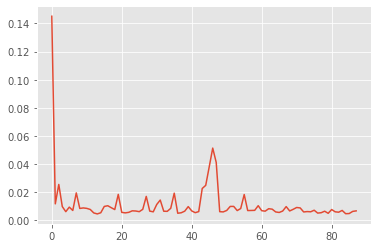

In [28]:
plt.plot(model.feature_importances_)

In [29]:
ft = np.flipud(np.argsort(model.feature_importances_))

In [30]:
np.array(dataset.columns[:-1])[ft]

array(['aod_550', 'pDUST_2', 'pDUST_3', 'pDUST_1', 'swrd', 'pDUST_0',
       'pWATER_3', 'sshf', 'pHNO3_3', 'ROOH_3', 'sphu_3', 'pSALT_3',
       'pH2SO4_3', 'albedo', 'pH2SO4_2', 'O3_3', 'ROOH_0', 'sphu_0',
       'pOCAR_3', 'relh_3', 'soim', 'CO_3', 'pNH3_3', 'hght', 'OH_2',
       'ROOH_1', 'OH_3', 'pres_1', 'pHNO3_2', 'pres_2', 'pres_0',
       'sphu_2', 'SO2_2', 'SO2_3', 'OH_1', 'pSALT_2', 'pres_3', 'NOX_0',
       'ROOH_2', 'NH3_3', 'O3_2', 'NOX_3', 'pOCAR_2', 'O3_1', 'slhf',
       'O3_0', 'sphu_1', 'SO2_0', 'HCNM_3', 'NOY_3', 'pWATER_0', 'OH_0',
       'pSALT_0', 'CO_2', 'pH2SO4_0', 'SO2_1', 'pNH3_2', 'TOL_2',
       'pHNO3_0', 'pHNO3_1', 'NOY_2', 'NH3_1', 'pWATER_2', 'sreh',
       'pSALT_1', 'pOCAR_0', 'NH3_2', 'NOX_1', 'pH2SO4_1', 'pOCAR_1',
       'CO_0', 'NH3_0', 'NOX_2', 'HCNM_2', 'HCNM_0', 'CO_1', 'pWATER_1',
       'TOL_1', 'relh_2', 'pNH3_1', 'HCNM_1', 'relh_0', 'TOL_0', 'pNH3_0',
       'TOL_3', 'NOY_1', 'NOY_0', 'relh_1'], dtype=object)

In [31]:
model.feature_importances_.mean()

0.011363636363636364

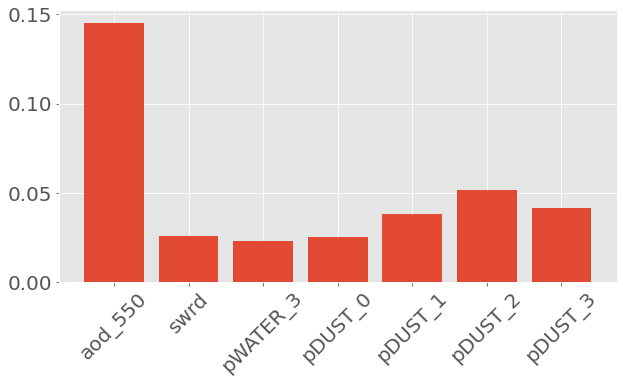

In [32]:
idx = np.where(model.feature_importances_> 0.02)

fig, ax = plt.subplots(figsize=(10,5))
plt.bar(dataset.columns[:-1][idx], model.feature_importances_[idx])

#plt.yscale('log')
_ = plt.xticks(rotation=45)
ax.tick_params(axis='both', which='major', labelsize=20)
#plt.savefig("rf_features_importance.jpg", dpi=100, pad_inches=12)

In [33]:
prediction = model.predict(x_test)
print(x_test.shape)
MAE = mean_absolute_error(y_test.flatten(), prediction)
print(f'RF validation MAE = {MAE}')

model_type = "RF"
# global figpath, which_inst, output_path
figpath=f"./figures/{config['region']}/{model_type}/{str(test_n)}/"
output_path = f"./models/{config['region']}/{model_type}/{str(test_n)}/"
if not os.path.exists(figpath) : os.mkdir(figpath)
if not os.path.exists(output_path) : os.mkdir(output_path)

pickle.dump(model, open(f'{output_path}/{model_type}.pkl', 'wb'))



(722565, 88)
RF validation MAE = 0.07009198129663974


In [34]:
#ax = plt.subplot()
#model_type = "random_forest"

#metrics_list = []

#model = cuml.RandomForestRegressor(accuracy_metric="mse",
#                                   random_state=seed,
#                                   n_streams=1,
#                                   max_features=1.0, n_bins=256,
#                                   min_samples_leaf=1,
#                                   min_samples_split=2,
#                                   #split_criterion=split_criterion,
#                                   n_estimators=200) #n_bins=256)

#start = time()
##model.fit(x_train,y_train.flatten())
#model.fit(input_layer,reference_layer.flatten())

#end = time()
#cost = np.round( (end - start)/60 , 2)
#print(f"FT finished in : {cost} minutes" ) 

## Get the mean absolute error on the validation data
#prediction = model.predict(x_test)

#_, metrics = set_metrics_str(ax, y_test.flatten(), prediction.flatten())
#metrics_list.append(metrics)
#print(pd.DataFrame.from_dict(metrics_list))
#plt.close()

## Deep encoder

In [35]:
#del model ; 
#del deepencoder

### Network architechture search

In [36]:
model_type = "deepencoder"
def build_model(hp):
    model = tf.keras.Sequential()

    model.add(
        tf.keras.layers.BatchNormalization( 
                 input_shape=(x_train.shape[1],),
                 #activation='relu',
                 #kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None),
                 #bias_initializer="zeros",
        )
    )

    for l in range(hp.Int("nlayers", min_value=6, max_value=10, step=2)) :
        model.add(
            tf.keras.layers.Dense(
                units=hp.Int(f"units_{l}", min_value=10, max_value=50, step=10),
                activation="relu",
                #kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None),
                #bias_initializer="zeros",
            )
        )

    #model.add(tf.keras.layers.Dense(y_test.shape[1], activation='relu'))
    model.add(tf.keras.layers.Dense(1,
                activation='relu',
                #kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None),
                #bias_initializer="zeros",
             )
    )

    model.compile(
#         optimizer=tf.keras.optimizers.Adam(
#             hp.Choice("learning_rate", values=[1e-2, 1e-3])
#         ),
        optimizer=tf.keras.optimizers.Adam(), #learning_rate=1e-3),
        loss="mean_squared_error",
        #metrics=["mean_absolute_error"],
    )
    return model

In [37]:
from keras_tuner import RandomSearch
from keras_tuner import BayesianOptimization

class MyTuner(BayesianOptimization):
#class MyTuner(RandomSearch):
    """
    https://github.com/keras-team/keras-tuner/issues/122
    """
    def run_trial(self, trial, *args, **kwargs):
        # You can add additional HyperParameters for preprocessing and custom training loops
        # via overriding `run_trial`
        #kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 1000, 3000, step=1000)
        #kwargs['epochs'] = trial.hyperparameters.Int('epochs', 10, 30)
        super(MyTuner, self).run_trial(trial, *args, **kwargs)

tuner = MyTuner(
    build_model,
    objective="val_loss",
    max_trials=100, # models
    executions_per_trial=1,
    overwrite=True,
    directory="models",
    project_name="tuner4",
    seed=seed
)

In [38]:
tuner.search_space_summary()

Search space summary
Default search space size: 7
nlayers (Int)
{'default': None, 'conditions': [], 'min_value': 6, 'max_value': 10, 'step': 2, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 50, 'step': 10, 'sampling': 'linear'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 50, 'step': 10, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 50, 'step': 10, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 50, 'step': 10, 'sampling': 'linear'}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 50, 'step': 10, 'sampling': 'linear'}
units_5 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 50, 'step': 10, 'sampling': 'linear'}


#### Training 

In [39]:
#early_stop = tf.keras.callbacks.EarlyStopping(
#                 monitor='val_loss',
#                 min_delta=0.001, patience=3, verbose=0,
#                 mode='min', baseline=0.2, restore_best_weights=True
#             )
#tensorboard = tf.keras.callbacks.TensorBoard(log_dir="models/log4")

# add by Juan for avoiding error in tuner.search  => ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).
#x_train0 = x_train.astype(np.float32)
#x_test0 = x_test.astype(np.float32)

#start = time()
#tuner.search(x_train, y_train,
#             epochs=100,
#             batch_size=int(y_train.size/2),
#             validation_data=(x_test, y_test),
#             verbose=3,
#             shuffle=True,
#             #callbacks=[early_stop], #, tensorboard ],
#            )
#end = time()
#cost = np.round( (end - start)/60 , 2)
#print(f"NAC finished in : {cost} minutes" ) 

In [40]:
#tuner.results_summary()

In [41]:
#model = tuner.get_best_models(1)[0]
# best_hps = tuner.get_best_hyperparameters(num_trials=10)
#model.summary()
#deepencoder = model

In [42]:
# models[0].__dir__()

In [43]:
#trials = tuner.oracle.get_best_trials(1)
#for trial in trials :
#    print(trial.trial_id)
#    print(trial.score)

In [44]:
#for i in range(9) :
#    pass
    #print(f"learning_rate : {best_hps[i].get('learning_rate')}")
    #print(f"loss : {best_hps[i].get('loss')}")

# tf.keras.utils.plot_model(
#     deepencoder,
#     to_file="model.png",
#     show_shapes=True,
#     show_layer_names=True,
#     rankdir="LR",
#     expand_nested=True,
#     dpi=76,
# )

#### Save/load model

In [45]:
#deepencoder.save("models/deepencoder4")

In [46]:
#deepencoder = tf.keras.models.load_model("models/deepencoder2")


### Fine tunning

In [47]:
tf.keras.backend.clear_session()
#del deepencoder
#del model


In [48]:
model_type='deepencoder'

deepencoder = tf.keras.Sequential()

deepencoder.add(
    tf.keras.layers.BatchNormalization(input_shape=(x_train.shape[1],))
)

deepencoder.add(
   tf.keras.layers.Dense(30,
       activation="relu",
   ),
)
deepencoder.add(
   tf.keras.layers.Dense(20,
       activation="relu",
   ),
)

deepencoder.add(
   tf.keras.layers.Dense(10,
       activation="relu",
   ),
)



deepencoder.add(
        tf.keras.layers.Dense(1,
        activation="relu",
    ),
)
deepencoder.compile(
    optimizer=tf.keras.optimizers.Adam(), #learning_rate=1e-5),
    loss="mean_squared_error",
    #metrics=["mean_squared_error"],
)

In [49]:
print(x_train.shape, y_train.shape)
print(deepencoder.summary())

(722564, 88) (722564, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 88)               352       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 30)                2670      
                                                                 
 dense_1 (Dense)             (None, 20)                620       
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 3,863
Trainable params: 3,687
Non-trainable params: 176
___________________________

In [50]:
logs = []
bss = np.asarray(np.exp(-np.arange(0.02, 10))*50000, dtype=np.int32)[0:-3]

epc = 20 ; bss = [y_train.size]#, 1000] #, 1000]
bss = [100]
start = time()

for bs in bss :
    print('Training for bs = '+ str(bs))
    logs.append(deepencoder.fit(x_train, y_train,
                    epochs=epc,
                    batch_size=bs, #2287, #22857, #10,
                    shuffle= True,
                    verbose=4,
                    validation_data=(x_test, y_test),
                    use_multiprocessing=True,
                    workers=-1,
                    )
               )
end = time()
cost = np.round( (end - start)/60 , 2)
print(f"Finished in : {cost} minutes" )
print(logs[0].params, logs[0].history.keys())
model = deepencoder

Training for bs = 100
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Finished in : 8.33 minutes
{'verbose': 4, 'epochs': 20, 'steps': 7226} dict_keys(['loss', 'val_loss'])


#### Validation

No handles with labels found to put in legend.


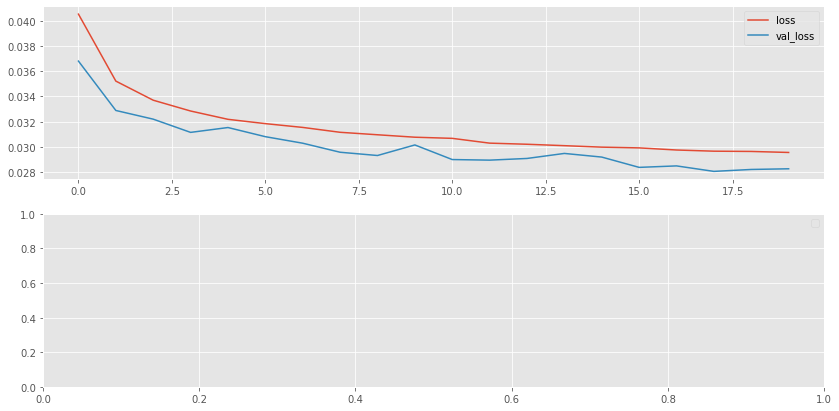

In [51]:
fig, axes = plt.subplots(nrows=2, figsize=figsize)
for i, log in enumerate(logs) :
    axes[0].axes.plot(np.arange(i*(epc-1),i*(epc-1)+epc), log.history['loss'], label="loss")
    #axes[0].axes.set_ylim([0.0152, 0.03])

    #axes[1].axes.plot(log.history['mean_squared_error'], label="mean_squared_error")
    axes[0].axes.plot(np.arange(i*(epc-1),i*(epc-1)+epc),log.history['val_loss'], label="val_loss")
    #axes[1].axes.plot(log.history['val_mean_squared_error'], label="val_mean_squared_error")
    [ ax.axes.legend() for ax in axes ]

#### Verification

In [52]:
loss = deepencoder.evaluate(x_test, y_test, verbose=True)
print(f"evaluation_loss : {loss}")

22581/22581 [==============================] - 29s 1ms/step - loss: 0.0283
evaluation_loss : 0.028257912024855614


In [53]:
weights = {}

In [54]:
weights['NN'] = np.asarray(model.weights[0])

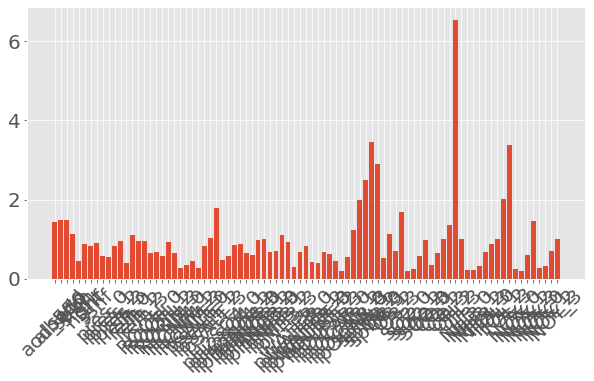

In [55]:
idx = np.where(model.weights[0] >0)

fig, ax = plt.subplots(figsize=(10,5))
plt.bar(dataset.columns[:-1][idx], np.asarray(model.weights[0])[idx])

#plt.yscale('log')
_ = plt.xticks(rotation=45)
ax.tick_params(axis='both', which='major', labelsize=20)
#plt.savefig("nn_features_importance.jpg", dpi=100, pad_inches=12)

In [56]:
prediction = model.predict(x_test)
print(x_test.shape)
MAE = mean_absolute_error(y_test.flatten(), prediction)
print(f'NN validation MAE = {MAE}')

model_type = "NN"
# global figpath, which_inst, output_path
figpath=f"./figures/{config['region']}/{model_type}/{str(test_n)}/"
output_path = f"./models/{config['region']}/{model_type}/{str(test_n)}/"
output_path2 = f"./models/{config['region']}/{model_type}/{str(test_n)}/{model_type}"
if not os.path.exists(figpath) : os.mkdir(figpath)
if not os.path.exists(output_path) : os.mkdir(output_path)
if not os.path.exists(output_path2) : os.mkdir(output_path2)

deepencoder.save(f"{output_path}/{model_type}")

22581/22581 [==============================] - 28s 1ms/step
(722565, 88)
NN validation MAE = 0.10541668723978234
INFO:tensorflow:Assets written to: ./models/AFRICA/NN/4//NN/assets


## TPOT (XGB)

In [57]:
#from tpot import TPOTRegressor
#model_type = 'tpot'

#tpot = TPOTRegressor(verbosity=2,
#              generations=100,
#              population_size=100,
#              random_state=seed,
#              #config_dict="TPOT cuML",
#              n_jobs=1,
#              cv=2,
#             )
#tpot.fit(input_layer[:100,:], reference_layer[:100])

In [58]:
#print(tpot.export())

In [59]:
#from tpot import TPOTRegressor
#model_type = 'tpot'

#import numpy as np
#import pandas as pd
#from sklearn.model_selection import train_test_split
#from sklearn.pipeline import make_pipeline, make_union
#from sklearn.preprocessing import MaxAbsScaler
#from tpot.builtins import ZeroCount

#from tpot.export_utils import set_param_recursive

#import xgboost as xgb

#tpot = make_pipeline(
#    #ZeroCount(),
#    xgb.XGBRegressor(alpha=1, learning_rate=0.1, max_depth=9, min_child_weight=14, n_estimators=100, n_jobs=1, objective="reg:squarederror", subsample=0.7500000000000001, verbosity=0)
#)

#set_param_recursive(tpot.steps, 'random_state', 10)

#tpot.fit(x_train, y_train)

#model = tpot

#pickle.dump(model, open(f'data/models/XGB0.pkl', 'wb'))


In [60]:
model_type = 'tpot'
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from xgboost import XGBRegressor
from tpot.export_utils import set_param_recursive
from tpot.builtins import ZeroCount

# Average CV score on the training set was: -0.02066391972671981
#exported_pipeline = XGBRegressor(alpha=10, learning_rate=1.0, max_depth=7, min_child_weight=17, n_estimators=100, 
#                                 n_jobs=1, objective="reg:squarederror", subsample=0.9000000000000001, tree_method="gpu_hist", verbosity=0)

model = make_pipeline(
    #ZeroCount(),
    XGBRegressor(
        alpha=1, learning_rate=0.1, max_depth=9,
        min_child_weight=17, n_estimators=100, n_jobs=1,
        objective="reg:squarederror", subsample=0.7500000000000001,
#        tree_method="gpu_hist", verbosity=0)
        verbosity=0)
)
# Fix random state in exported estimator
if hasattr(model, 'random_state'):
    setattr(model, 'random_state', 10)

model.fit(x_train, y_train)


Pipeline(steps=[('xgbregressor',
                 XGBRegressor(alpha=1, base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=9,
                              min_child_weight=17, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=1, num_parallel_tree=1, predictor='auto',
                              random_state=0, reg_alpha=1, reg_lambda=1,
                              scale_pos_weight=1, subsample=0.7500000000000001,
                              tree_method='exact', validate_parameters=1,
                              verbosity=0))])

In [61]:
model0 = model

In [62]:
model = model0.named_steps['xgbregressor']

prediction = model.predict(x_test)

MAE = mean_absolute_error(y_test, prediction)
print(f'XGB validation MAE = {MAE}')

model_type = "XGB"
# global figpath, which_inst, output_path
figpath=f"./figures/{config['region']}/{model_type}/{str(test_n)}/"
output_path = f"./models/{config['region']}/{model_type}/{str(test_n)}/"
if not os.path.exists(figpath) : os.mkdir(figpath)
if not os.path.exists(output_path) : os.mkdir(output_path)

pickle.dump(model, open(f'{output_path}/{model_type}.pkl', 'wb'))


XGB validation MAE = 0.09378588030065724


## LINEAR 

In [63]:
e = dataset.sort_values("MODIS", axis=0)

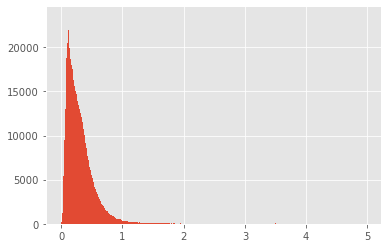

In [64]:
a,b,c = plt.hist(e.values[:,-1], bins=1000)

In [65]:
sample_weight=(a.max()-a)/a.max()

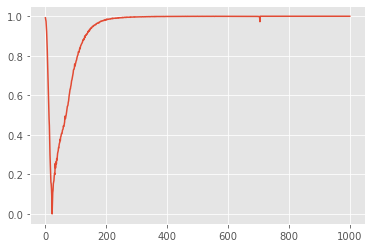

In [66]:
plt.plot(sample_weight)

In [67]:
d = np.interp(np.arange(e.shape[0]), np.linspace(0, e.shape[0], 1000), sample_weight)

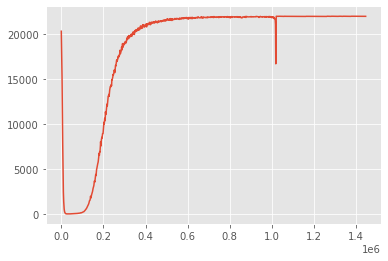

In [68]:
plt.plot(np.exp(d*10))

In [69]:
#input_layer, reference_layer = e.values[:,:-1], e.values[:,-1]

In [70]:
model_type = 'linear'
model = linear_model.LinearRegression(n_jobs=-1, fit_intercept=False, positive=False)

start = time()
#model.fit( input_layer,reference_layer) #, sample_weight=np.exp(d*10))
model.fit( x_train, y_train) #, sample_weight=np.exp(d*10))

end = time()
cost = np.round( (end - start) , 2)
print(f"FT finished in : {cost} seconds" )

prediction = model.predict(x_test)

print(x_test.shape)
MAE = mean_absolute_error(y_test.flatten(), prediction)
print(f'MLR validation MAE = {MAE}')

# save MLR by Juan
model_type = "MLR"
# global figpath, which_inst, output_path
figpath=f"./figures/{config['region']}/{model_type}/{str(test_n)}/"
output_path = f"./models/{config['region']}/{model_type}/{str(test_n)}/"
if not os.path.exists(figpath) : os.mkdir(figpath)
if not os.path.exists(output_path) : os.mkdir(output_path)

pickle.dump(model, open(f'{output_path}/{model_type}.pkl', 'wb'))

FT finished in : 6.48 seconds
(722565, 88)
MLR validation MAE = 0.12603142849411902


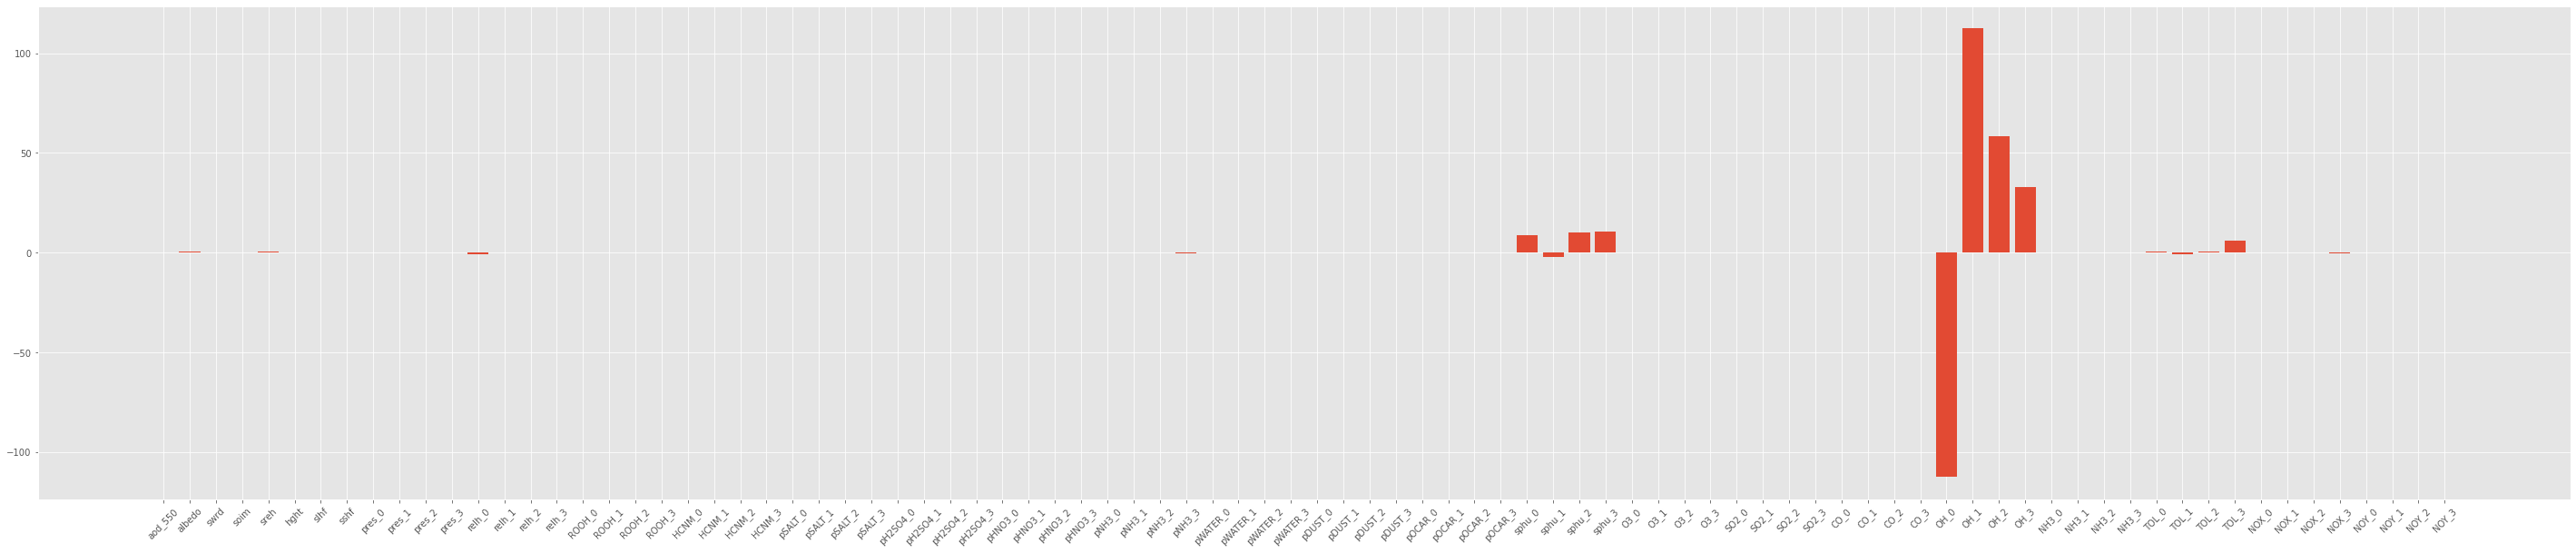

In [71]:
fig, ax = plt.subplots(figsize=(50,10))
plt.bar(dataset.columns[:-2], model.coef_.flatten())
#plt.yscale('log')
_ = plt.xticks(rotation=45)
#plt.savefig("linear.jpg")

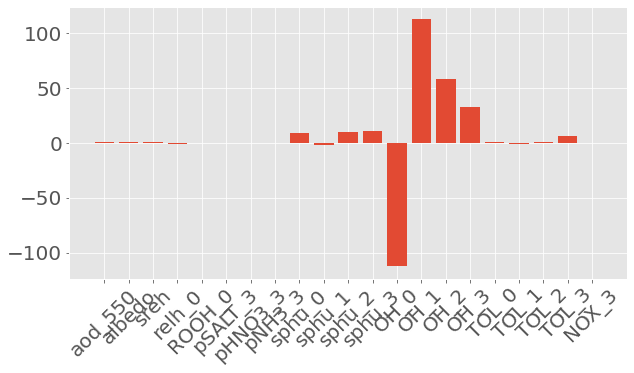

In [72]:
idx = np.where(np.abs(model.coef_.flatten())>0.1)

fig, ax = plt.subplots(figsize=(10,5))
plt.bar(dataset.columns[:-1][idx], model.coef_.flatten()[idx])

#plt.yscale('log')
_ = plt.xticks(rotation=45)
ax.tick_params(axis='both', which='major', labelsize=20)
#plt.savefig("linear_coef.jpg", dpi=100, pad_inches=12)

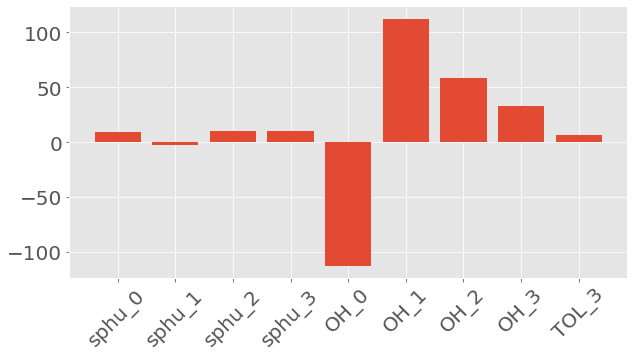

In [73]:
idx = np.where(np.abs(model.coef_.flatten())> 1)

fig, ax = plt.subplots(figsize=(10,5))
plt.bar(dataset.columns[:-1][idx], model.coef_.flatten()[idx])

#plt.yscale('log')
_ = plt.xticks(rotation=45)
ax.tick_params(axis='both', which='major', labelsize=20)
#plt.savefig("linear_coef.jpg", dpi=100, pad_inches=12)

In [74]:
class line_model():
    def __init__(self, origin, a,b):
        self.a = a
        self.b = b
        self.origin = origin
    def predict(self, data):
        return (self.origin+self.b)/(1+self.a)

# Inference

### no log 

In [75]:
#no log
def predict_date(date, model, pca, do_plot=None, save_output=None):
    print(date, end=', ')
    #i=2; j=0; vmax=2; vmin=0.0001; cbar_norm='sqrt'
    i=2; j=0; vmax=1; vmin=0.0; cbar_norm='lin'
    metrics = {}
    metrics0 = {}
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,10), subplot_kw={'projection': projection}, constrained_layout=True)

    if save_output :


        input_layer_ver0, reference_layer_ver = load_input_output2(date=date, do_chimere=True, do_modis=True, common_na_mask=False, **config)
        # Removing the equator region coz of low fire emissions issue
        input_layer_ver0 = input_layer_ver0[input_layer_ver0.iloc[:,1] > 10].values
        reference_layer_ver = reference_layer_ver[reference_layer_ver.iloc[:,1] > 10].values
        chim_aod = np.copy(input_layer_ver0[:,2])
        #input_layer_ver0[:,2:] = scaler.transform(input_layer_ver0[:,2:])
        #input_layer_ver0[:,2:] = minmax_scale(input_layer_ver0[:,2:], feature_range=(-1, 1), axis=1)
        #model = line_model(chim_aod, 0.79, 0.2) # 1d model from bias correlation with chimere aod tire figure paper
        if input_layer_ver0.shape[0] < 200 : # low exploitable data points
            #continue
            return None, None, None, None
        #Predict on CHIMERE unfiltered
        if model_type == "lwr" :
            prediction = model.predict(input_layer_ver0[:,2])
        elif model_type == "local_regression" :
            #input_layer_ver = minmax_scale(input_layer_ver0[:,2:], feature_range=(-1, 1), axis=0)
            #prediction = model.predict(input_layer_ver0[:,2:])
            prediction = model.predict(np.matmul(pca.components_, minmax_scale(input_layer_ver0[:,2:], feature_range=(-1, 1), axis=1).T).T) #KNN

        elif model_type in ["knn"]: #, "random_forest"]:
            #prediction = model.predict(input_layer_ver0[:,2:]) # RF
            #prediction = model.predict(np.matmul(pca.components_, minmax_scale(input_layer_ver0[:,2:], feature_range=(-1, 1), axis=1).T).T) #KNN
            prediction = model.predict(np.matmul(pca.components_, input_layer_ver0[:,2:].T).T)

        else :
            input_layer_ver = input_layer_ver0 #input_layer_ver = minmax_scale(input_layer_ver0, feature_range=(-1, 1), axis=0)
            #input_layer = normalize(input_layer.T)
            prediction = model.predict(input_layer_ver0[:,2:]) #, use_multiprocessing=False)
        prediction = prediction.reshape(prediction.size,1)
        axes[2,1], metrics = set_metrics_str(axes[2,1], chim_aod, prediction[:,j])

        out_pred_ds = xr.Dataset()
        out_pred_ds.coords['lon'] = (['south_north','west_east'], input_layer_ver0[:,0].reshape(63,-1)) # reshape cz this is subdomain 10°N threshold
        out_pred_ds.coords['lat'] = (['south_north','west_east'], input_layer_ver0[:,1].reshape(63,-1))
        out_pred_ds[f'optdaero_{wv}'] = (['south_north','west_east'], chim_aod.reshape(63,-1))
        out_pred_ds[f'optdaero_{wv}_corr'] = (['south_north','west_east'], prediction.reshape(63,-1))

        out_pred_ds.to_netcdf( f'{output_path}/out.{date}00_01.nc', mode='w')
        out_pred_ds.close()

    if do_plot :
        scatter_plot1(axes[0,0], input_layer_ver0[:,0], input_layer_ver0[:,1], chim_aod, vmin=vmin, vmax=vmax, title="Raw CHIMERE", norm=cbar_norm)
        scatter_plot1(axes[1,0], input_layer_ver0[:,0], input_layer_ver0[:,1], prediction[:,j], vmin=vmin, vmax=vmax, title="ML-Corrected CHIMERE", norm=cbar_norm)
        scatter_plot1(axes[2,0], reference_layer_ver[:,0], reference_layer_ver[:,1], reference_layer_ver[:,2] , vmin=vmin, vmax=vmax, title=f"MODIS {which_inst}", norm=cbar_norm)

        #FB
        #scatter_plot1(axes[2,1], input_layer_ver0[:,0], input_layer_ver0[:,1], 2*(prediction[:,j] - input_layer_ver0[:,i])/(input_layer_ver0[:,i] + prediction[:,j]) , vmin=-2, vmax=2, title="FB corrected vs raw", cmap="bwr")
        scatter_plot1(axes[2,1], input_layer_ver0[:,0], input_layer_ver0[:,1], prediction[:,j]-chim_aod , cmap="PiYG", vmin=-3, vmax=3, title="AOD DIFF corrected-raw")

    #Predict using filtered data
    input_layer_ver0, reference_layer_ver = load_input_output2(date=date, **config, common_na_mask=True,
                                                             do_modis=True, do_chimere=True)

    # Removing the equator region coz of low fire emissions issue
    input_layer_ver0 = input_layer_ver0[input_layer_ver0.iloc[:,1] > 10].values
    reference_layer_ver = reference_layer_ver[reference_layer_ver.iloc[:,1] > 10].values

    chim_aod = np.copy(input_layer_ver0[:,2])
    #model = line_model(chim_aod, 0.79, 0.2) # 1d model from bias correlation with chimere aod tire figure paper

    #input_layer_ver0[:,2:] = scaler.transform(input_layer_ver0[:,2:])
    #input_layer_ver0[:,2:] = minmax_scale(input_layer_ver0[:,2:], feature_range=(-1, 1), axis=1)

    if model_type == "lwr" :
        prediction = model.predict(input_layer_ver0[:,2])
    elif model_type == "local_regression" :
        #prediction = model.predict(input_layer_ver0[:,2:])
        prediction = model.predict(np.matmul(pca.components_, minmax_scale(input_layer_ver0[:,2:], feature_range=(-1, 1), axis=1).T).T) #KNN

    elif model_type in ["knn"] :
        #prediction = model.predict(input_layer_ver0[:,2:])
        #prediction = model.predict(np.matmul(pca.components_, minmax_scale(input_layer_ver0[:,2:], feature_range=(-1, 1), axis=1).T).T)
        prediction = model.predict(np.matmul(pca.components_, input_layer_ver0[:,2:].T).T)

    else :
        input_layer_ver = input_layer_ver0 #input_layer_ver = minmax_scale(input_layer_ver0, feature_range=(-1, 1), axis=0)
        #input_layer = normalize(input_layer.T)
        prediction = model.predict(input_layer_ver0[:,2:]) #, use_multiprocessing=False)
    prediction = prediction.reshape(prediction.size,1)

    if do_plot :
        axes[0,1], metrics0 = set_metrics_str(axes[0,1], chim_aod, reference_layer_ver[:,i])

        scatter_plot1(axes[1,1], input_layer_ver0[:,0], input_layer_ver0[:,1], 2*(prediction[:,j] - reference_layer_ver[:,2])/(reference_layer_ver[:,2] + prediction[:,j]) ,
                      vmin=-2, vmax=2, title=f"FB corrected vs {which_inst}", cmap="bwr")
        #mae = np.sum(np.abs(prediction[:,j] - reference_layer_ver[:,2]))/prediction[:,j].size
        #axes[1,1].axes.legend([f"MAE={mae.round(3)}"])
        axes[1,1], metrics = set_metrics_str(axes[1,1], reference_layer_ver[:,i], prediction[:,j])

        scatter_plot1(axes[0,1], input_layer_ver0[:,0], input_layer_ver0[:,1], 2*(chim_aod - reference_layer_ver[:,2] )/(chim_aod + reference_layer_ver[:,2]) , vmin=-2, vmax=2, title=f"FB raw vs {which_inst}", cmap="bwr")
        #mae = np.sum(np.abs(input_layer_ver0[:,i] - reference_layer_ver[:,2]))/input_layer_ver0[:,i].size
        #axes[0,1].axes.legend([f"MAE={mae.round(3)}"])

    if do_plot :
        if date in train_dates :
            plt.suptitle(f"{config['model_type']} {date[0:4]}-{date[4:6]}-{date[6:8]}* test:{config['test_n']}", fontsize=20)
        else :
            plt.suptitle(f"{config['model_type']} {date[0:4]}-{date[4:6]}-{date[6:8]} test:{config['test_n']}", fontsize=20)

        plt.savefig(f"{figpath}/result_"+ str(date) + ".jpeg", dpi=150); plt.close()
    plt.close()
    return metrics, metrics0, input_layer_ver0, prediction

## Plot & save nc predictions

In [76]:
def plot_dates (valid_dates, model, pca, do_plot=False, save_output=False) :
    import pandas as pd
    import numpy as np
    from time import time
    print("do_plot: ",do_plot)
    print("save_output: ",save_output)
    log_reference =    pd.DataFrame()
    log_prediction =   pd.DataFrame()
    inference_cost =   np.empty(0)

    for date in valid_dates :
    #from multiprocessing import Pool
    #with Pool(2) as p :
    #     p.map(plot_date, valid_dates)
        start = time()
        metrics, metrics0, input_layer, prediction =  predict_date(date, model, pca, do_plot=do_plot, save_output=save_output)
        end = time()
        inference_cost = np.append(inference_cost, end-start)
        log_reference   = log_reference.append(metrics0, ignore_index=True)
        log_prediction = log_prediction.append(metrics, ignore_index=True)
    return log_reference, log_prediction, inference_cost

In [77]:
config['model_type'] = model_type

In [78]:
#model = tf.keras.models.load_model("models/deepencoder4")
#model = pickle.load(open('grad_boost.pkl', 'rb'))

In [79]:

#valid_dates= count_days("20211220", "20211231", "%Y%m%d") + count_days("20210510", "20210520", "%Y%m%d")# to do save prediction file
#dates = ["20210225"]
log_reference, log_prediction, inference_cost = plot_dates(config['valid_dates']+config['valid_dates'], model, None, do_plot=True, save_output=True)
cost = inference_cost.sum()
## MODEL INFO
f = open(f'{figpath}/config_{test_n}.yaml', 'w+')
yaml.dump(config, f, allow_unicode=True)
yaml.dump(
    {
        "model_type": model_type,
        "valid_dates" : valid_dates,
        "train_dates" : train_dates,
        "Daily_average_CHIMERE.raw_vs_MODIS":float(np.sum(log_reference.values)/len(valid_dates)),
        "Daily_average_testing_score":float(np.sum(log_prediction.values)/len(valid_dates)),
        "train_cost_minutes":np.float(cost),
        "Daily_average_prediction_cost_minutes":float(np.sum(inference_cost)/60/len(valid_dates)),
        "figpath":figpath,
        "output_path":output_path,
    }, f, default_flow_style=False)

if model_type == "knn":
    yaml.dump(config, f, allow_unicode=True)
    yaml.dump({
        "k":k,
        "npca":nclusters}, f, default_flow_style=False)

do_plot:  True
save_output:  True
20210121, 20210122, 20210123, 20210124, 20210125, 20210126, 20210127, 20210128, 20210129, 20210130, 20210131, 20210221, 20210222, 20210223, 20210224, 20210225, 20210226, 20210227, 20210228, 20210321, 20210322, 20210323, 20210324, 20210325, 20210326, 20210327, 20210328, 20210329, 20210330, 20210331, 20210421, 20210422, 20210423, 20210424, 20210425, 20210426, 20210427, 20210428, 20210429, 20210430, 20210521, 20210522, 20210523, 20210524, 20210525, 20210526, 20210527, 20210528, 20210529, 20210530, 20210531, 20210621, 20210622, 20210623, 20210624, 20210625, 20210626, 20210627, 20210628, 20210629, 20210630, 20210721, 20210722, 20210723, 20210724, 20210725, 20210726, 20210727, 20210728, 20210729, 20210730, 20210731, 20210821, 20210822, 20210823, 20210824, 20210825, 20210826, 20210827, 20210828, 20210829, 20210830, 20210831, 20210921, 20210922, 20210926, 20210927, 20210928, 20210929, 20210930, 20211021, 20211022, 20211023, 20211024, 20211025, 20211026, 202110

## Bias analysis

### Median bias

In [80]:
dates = config['valid_dates']

In [81]:
config['output_path'] = output_path
config['figpath'] = figpath

In [82]:
a = []
b = []
for date in dates :
    print(date, end=",")
    chim_ds = xr.open_dataset(f"{config['output_path']}/out.{date}00_01.nc")
    modis_ds = load_datasets(date=date, do_chimere=False, do_modis=True, **config)
    o = modis_ds.lat>10
    a.append(chim_ds['optdaero_550.0_corr'].data)    
    b.append(modis_ds.AOD_550_Dark_Target_Deep_Blue_Combined.where(o).data[37:,:])

20210121,20210122,20210123,20210124,20210125,20210126,20210127,20210128,20210129,20210130,20210131,20210221,20210222,20210223,20210224,20210225,20210226,20210227,20210228,20210321,20210322,20210323,20210324,20210325,20210326,20210327,20210328,20210329,20210330,20210331,20210421,20210422,20210423,20210424,20210425,20210426,20210427,20210428,20210429,20210430,20210521,20210522,20210523,20210524,20210525,20210526,20210527,20210528,20210529,20210530,20210531,20210621,20210622,20210623,20210624,20210625,20210626,20210627,20210628,20210629,20210630,20210721,20210722,20210723,20210724,20210725,20210726,20210727,20210728,20210729,20210730,20210731,20210821,20210822,20210823,20210824,20210825,20210826,20210827,20210828,20210829,20210830,20210831,20210921,20210922,20210926,20210927,20210928,20210929,20210930,20211021,20211022,20211023,20211024,20211025,20211026,20211027,20211028,20211029,20211030,20211031,20211121,20211122,20211123,20211124,20211125,20211126,20211127,20211128,20211129,20211130,2

In [83]:
#chim_corr = np.asarray(np.exp(np.squeeze(a)))
chim_corr = np.asarray(np.squeeze(a))

modis_aod = np.asarray(b)
bias = chim_corr-modis_aod 

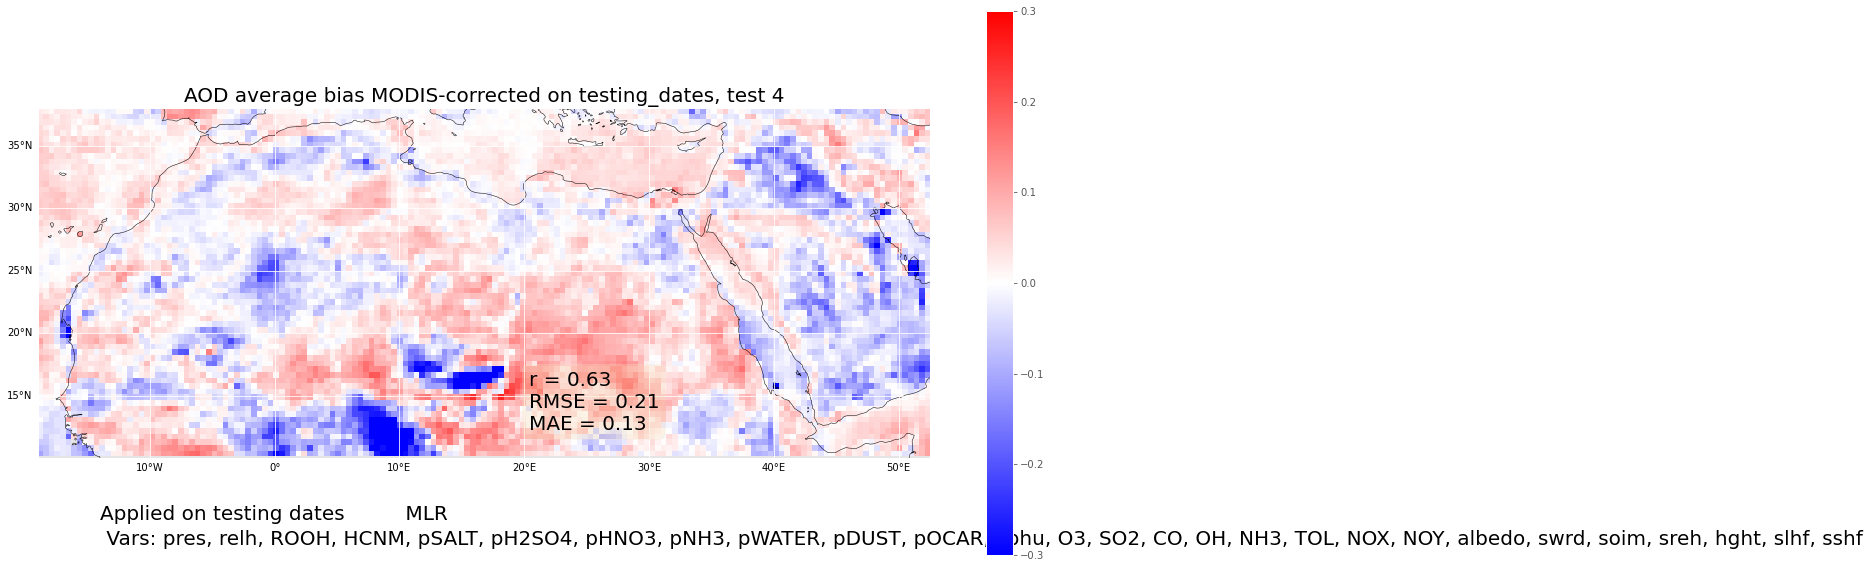

In [84]:
fig = plt.figure(figsize=(20,10))
fontsize = 10
ax = fig.add_subplot(projection=ccrs.PlateCarree())
im = plt.pcolormesh(chim_ds.lon, chim_ds.lat, np.nanmean(bias, axis=0), cmap="bwr", vmin=-0.3, vmax=0.3)# cmap='YlOrBr') #, vmin=0, vmax=1)
ax.coastlines()
plt.title(f"AOD average bias MODIS-corrected on testing_dates, test {config['test_n']}", fontsize=20)
plt.colorbar()
ax, txt = set_metrics_str(ax,modis_aod.flatten(), chim_corr.flatten(), fontsize=20 ) # lat 10 == idx 37
#ax, txt = set_metrics_str(ax,optdaero.flatten(), modis_aod.flatten(), fontsize=20 )
plt.ylim([10,chim_ds.lat.max()])
plt.xlim([chim_ds.lon.min(), chim_ds.lon.max()])

gl = im.axes.gridlines(draw_labels=True)
gl.top_labels, gl.ylabels_right = False, False
gl.xlabel_style, gl.ylabel_style = {'fontsize': fontsize}, {'fontsize': fontsize}

plt.text(-14,5,f"Applied on testing dates", fontsize=20)
plt.text(10,5,f" {config['model_type']}", fontsize=20)
plt.text(-14,3,f" Vars: {', '.join(config['var_3d_ch'] + config['var_2d_ch'] )}", fontsize=20)
plt.savefig(f"{config['figpath']}/{config['model_type']}_average_bias.jpg")

### correlation

In [85]:
from scipy.stats import bootstrap
import scipy
import pickle
import tensorflow as tf; print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib
plt.style.use('default')
import warnings;  warnings.filterwarnings('ignore')
fontsize=20


Num GPUs Available:  0


In [86]:
DTest = pickle.load(open(f"./models/{config['region']}/DTest_{config['test_n']}.pkl", 'rb'))
DTest = DTest[~DTest.MODIS.isna()]

DTrain = pickle.load(open(f"./models/{config['region']}/DTrain_{config['test_n']}.pkl", 'rb'))
DTrain = DTrain[~DTrain.MODIS.isna()]

In [87]:
dataset0 = pd.concat([DTrain, DTest], axis=0)
RAW2 = dataset0.aod_550.values- dataset0.MODIS

In [88]:
corr = DTest.corr()

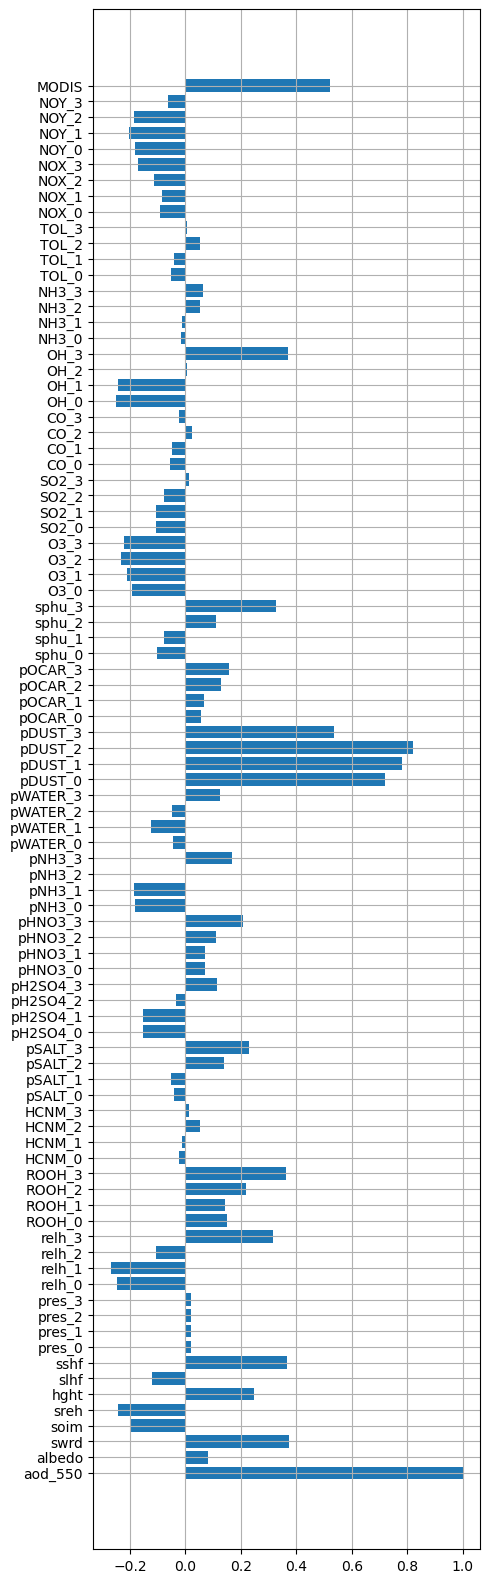

In [89]:
fig, ax = plt.subplots(figsize=(5,20))
ax.barh(corr.columns, corr.aod_550)
plt.grid()

In [90]:
#weights = pickle.load(open(f'weights.pkl', 'rb'))

In [91]:
#weights=weights.set_index("VAR")

In [92]:
#mean = DTrain.iloc[:,2:-2].mean(axis=0)

In [93]:
#for model in [ "RF", "XGB", "MLR", "NN"]:
#    fig, ax = plt.subplots(ncols=1,nrows=1, figsize=(3,3))
#    weights = pickle.load(open(f'weights.pkl', 'rb'))
#    weights=weights.set_index("VAR")
#    if model in []:
#        print(model)
#        #mean = DTrain.iloc[:,2:-2].mean(axis=0)
#        #weights = weights.multiply(mean, axis="rows")
#    weights0 = np.abs(weights).sort_values(model, ascending=False)
#    im = weights0[model].iloc[0:5].plot.bar(title=model, ax=ax, fontsize=10)
#    plt.savefig(model)

### relative bias

In [94]:
#relative bias
######## Choose the model : NN, XGB, RF or MLR ##########
model_types = ["MLR", "NN", "RF", "XGB"]
######################
biases = {}
biases["RAW"] = (DTest.aod_550.values- DTest.MODIS)/ DTest.MODIS


for model_type in model_types :

    figpath=f"./figures/{config['region']}/{model_type}/{str(test_n)}/"
    output_path = f"./models/{config['region']}/{model_type}/{str(test_n)}/"
    
    if model_type == "NN" :
        model = tf.keras.models.load_model(f"{output_path}/{model_type}")
    else :
        model = pickle.load(open(f'{output_path}/{model_type}.pkl', 'rb'))
 
    
    x_test1, y_test1 = DTest.iloc[:,:-2].values, DTest.iloc[:,-1].values.reshape(-1,1)
    print(model_type)
    prediction = model.predict(x_test1)
        
    biases[model_type] = (prediction.flatten() - DTest.MODIS)/ DTest.MODIS


MLR
NN
22581/22581 [==============================] - 32s 1ms/step
RF
XGB


In [95]:
#absolute bias
######## Choose the model : NN, XGB, RF or MLR ##########
model_types = ["MLR", "NN", "RF", "XGB"]
######################
biases = {}
prediction = {}
biases["RAW"] = DTest.aod_550.values- DTest.MODIS

for model_type in model_types :
    figpath=f"./figures/{config['region']}/{model_type}/{str(test_n)}/"
    output_path = f"./models/{config['region']}/{model_type}/{str(test_n)}/"
    
    if model_type == "NN" :
        model = tf.keras.models.load_model(f"{output_path}/{model_type}")
    else :
        model = pickle.load(open(f'{output_path}/{model_type}.pkl', 'rb'))
 

    prediction[model_type] = model.predict(DTest.iloc[:,:-2]).flatten()
    biases[model_type] = prediction[model_type].flatten() - DTest.MODIS

22581/22581 [==============================] - 35s 2ms/step


In [96]:
# bias_shuffled = bias.sample(frac=1)
# bootstrap(bias_shuffled.values.reshape(1,-1)[:,:18402], np.mean, confidence_level=0.9, random_state=seed)

In [97]:
biases = pd.DataFrame(biases)
prediction = pd.DataFrame(prediction)

In [98]:
skew = scipy.stats.skew(biases)

In [99]:
var = biases.var()

In [100]:
np.round(var.values.T, 4)

array([0.3165, 0.0438, 0.0281, 0.0148, 0.0213])

In [101]:
#  textstr = '\n'.join((
#         "         $\gamma$         $\sigma{^2}$", 
#         f'RAW {np.round(skew[0],2)},    {np.round(var[0], 2)}   ',
#         f'MLR {np.round(skew[1],2)},     {np.round(var[1], 2)}',
#         f"NN   {np.round(skew[2],2)},   {np.round(var[2], 2)}",
#         f"RF    {np.round(skew[3],2)},   {np.round(var[3], 2)}",
#         f"XGB {np.round(skew[4],2)},   {np.round(var[4], 2)}",

#         ))

Text(0, 0.5, 'Occurrence')

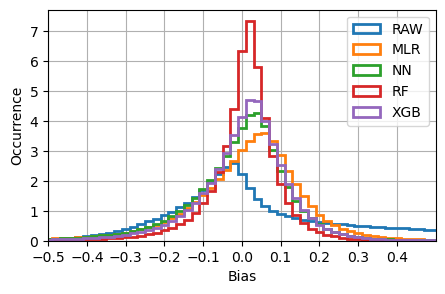

In [102]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,3))
for i in biases :
    a = ax.hist(biases[i], histtype='step', density=True, stacked=True, bins=np.arange(-5.01,5.01,0.02), linewidth=2, label=i)

# props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
# ax.text(0.05, 0.950, textstr, transform=ax.transAxes, verticalalignment='top', bbox=props)

plt.legend()
plt.xlim([-0.5, 0.5])
plt.xticks(np.arange(-0.5, 0.5, 0.1))
plt.grid()
plt.xlabel("Bias")
plt.ylabel("Occurrence")

#plt.savefig("correction_bias.jpg")

In [103]:
biases.describe()

,RAW,MLR,NN,RF,XGB
count,722565.000000,722565.000000,722565.000000,722565.000000,722565.000000
mean,0.215749,-0.000087,-0.011745,0.000638,-0.000171
std,0.562549,0.209391,0.167690,0.121753,0.146104
min,-3.568857,-4.522079,-3.294007,-3.262723,-3.337634
25%,-0.087313,-0.066357,-0.072405,-0.032958,-0.053910
50%,0.023783,0.026443,0.009444,0.013114,0.016073
75%,0.365453,0.099283,0.070394,0.052074,0.072721
max,10.784272,1.698950,3.067896,2.071819,2.255547


In [104]:
d = pd.concat([biases, DTest.MODIS], axis=1, names=['RAW', 'MLR','NN', 'RF', 'XGB', 'MODIS'])

### bias vs CHIMERE

In [105]:
fontsize=20

colors = ["C0","C1", "C2", "C3", "C4"]
xbin = np.arange(0,8,0.02)
ybin = np.arange(-4,4,.02)

X,Y = np.meshgrid(xbin, ybin)
for i, model  in enumerate(biases.columns) :
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,4)) #, sharex=True, sharey=True)

    #ax = plt.sca(axes[i])
    #plt.plot(np.zeros(8), c='k')
    a = scipy.stats.binned_statistic_2d(DTest.aod_550, biases[model], biases[model], statistic="count", 
                                        bins=[xbin, ybin])
    print('done')

    m = plt.pcolormesh(X, Y, a.statistic.T, norm=matplotlib.colors.LogNorm(), cmap='magma', vmin=1, vmax=3000)
    a,b = np.polyfit(DTest.aod_550, biases[model], 1)
    textstr = '\n'.join((
        
        f"a = {np.round(a,2)}",
        f"b = {np.round(b,2)}",
        )
    )
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
    plt.text(0.6, 0.20, textstr, transform=axes.transAxes,
              verticalalignment='top', bbox=props, fontsize=fontsize-5)

    plt.plot(np.arange(8), np.arange(8)*a+b, color='g',linewidth=3)

    axes.set_aspect('auto')
    plt.xticks(np.arange(0, 8, 1))
    plt.plot(np.arange(0,8), linewidth=.8, c='grey')
    plt.plot(np.arange(0,8), -1*np.arange(0,8), linewidth=.8, c='grey')

    plt.xlim([xbin.min(), xbin.max()])

    plt.ylim(ybin.min(), ybin.max())
    plt.ylabel(model  + ' bias' , fontsize=fontsize)

    plt.yticks(np.arange(-4,4), fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.grid()
    plt.xlabel('CHIMERE AOD', fontsize=fontsize)
    #plt.suptitle('Bias (AOD difference model-MODIS)')
    plt.gcf().subplots_adjust(bottom=0.17, left=0.23)

    figpath=f"./figures/{config['region']}/{model}/{str(test_n)}/"
    output_path = f"./models/{config['region']}/{model}/"
    if not os.path.exists(output_path) : os.mkdir(output_path)
    output_path = f"./models/{config['region']}/{model}/{str(test_n)}/"
    if not os.path.exists(output_path) : os.mkdir(output_path)
    
    plt.savefig(f'{output_path}/{model}_biases_vs_chim.png', dpi=100)
    plt.close()

done
done
done
done
done


### bias vs CHIMERE whole year

In [106]:
d = dataset0.drop(['date'], axis=1)

In [107]:
corr = d.corr()

In [108]:
corr0 = corr.iloc[:,-1]

In [109]:
corr1 = np.abs(corr0).sort_values(ascending=False)

<BarContainer object of 18 artists>

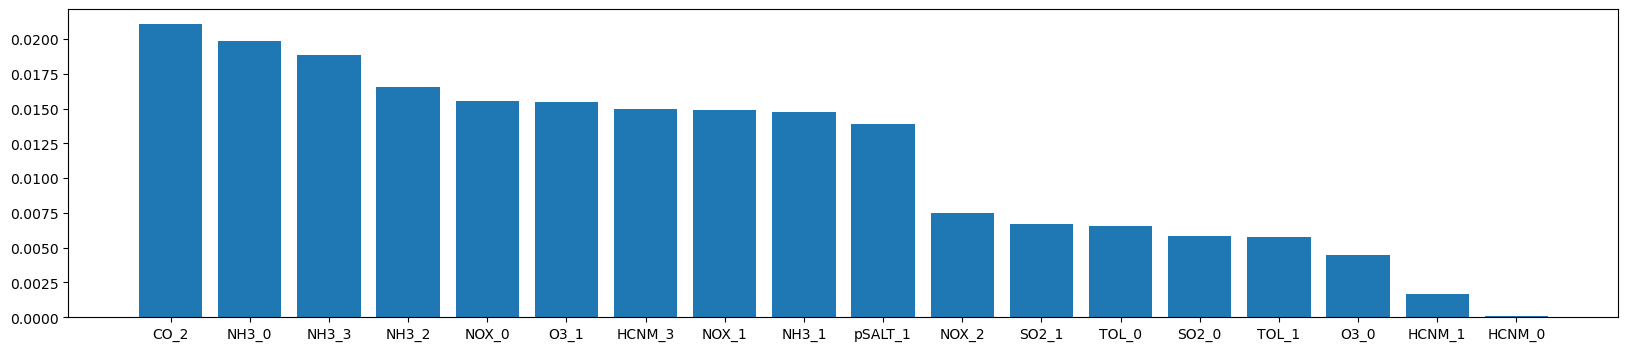

In [110]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,4))
plt.bar(corr1.index[71:], corr1.values[71:]) 

In [111]:
#fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,4)) #, sharex=True, sharey=True)
#x = np.arange(0,8,0.02); y = np.arange(-4,4,.02)
#X,Y = np.meshgrid(x,y)
##ax = plt.sca(axes[i])
##plt.plot(np.zeros(8), c='k')
#a = scipy.stats.binned_statistic_2d(dataset0.values, RAW2, RAW2, statistic="count", 
#                                    bins=[np.arange(0,8,0.02), np.arange(-4,4,.02)])
#print('done')

#m = plt.pcolormesh(X, Y, a.statistic.T, norm=matplotlib.colors.LogNorm(), cmap='magma', vmin=1, vmax=3000)
#a,b = np.polyfit(dataset0.aod_550, RAW2, 1)
#textstr = '\n'.join((

#    f"a = {np.round(a,2)}",
#    f"b = {np.round(b,2)}",
#    )
#)
#props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
#plt.text(0.6, 0.20, textstr, transform=axes.transAxes,
#         verticalalignment='top', bbox=props, fontsize=fontsize-5)

#plt.plot(np.arange(8), np.arange(8)*a+b, color='g',linewidth=3)

## cb = plt.colorbar(m)
## cb.ax.tick_params(labelsize=fontsize)
## cb.set_label(label='Occurrence', fontsize=fontsize-5)

#axes.set_aspect('auto')
#plt.xlim([0,8])
#plt.xticks(np.arange(0, 8, 1))

#plt.ylim(-4,4)
#plt.ylabel( 'RAW bias' , fontsize=fontsize)

#plt.yticks(np.arange(-4,4), fontsize=fontsize)
#plt.xticks(fontsize=fontsize)
#plt.grid()
#plt.xlabel('CHIMERE AOD', fontsize=fontsize)
##plt.suptitle('Bias (AOD difference model-MODIS)')
#plt.gcf().subplots_adjust(bottom=0.17, left=0.23)
##plt.savefig("raw_all_chimere.jpg")

### bias vs MODIS

In [112]:
fontsize=20

colors = ["C0","C1", "C2", "C3", "C4"]
xbin = np.arange(0,4,0.02)
ybin = np.arange(-4,4,.02)

X,Y = np.meshgrid(xbin, ybin)
for i, model  in enumerate(prediction.keys()) :
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,4)) #, sharex=True, sharey=True)

    #ax = plt.sca(axes[i])
    #plt.plot(np.zeros(8), c='k')
    a = scipy.stats.binned_statistic_2d(DTest.MODIS, biases[model], biases[model], statistic="count", 
                                        bins=[xbin, ybin])

    print('done')

    m = plt.pcolormesh(X, Y, a.statistic.T, norm=matplotlib.colors.LogNorm(), cmap='cividis', vmin=1, vmax=3000)
    a,b = np.polyfit(DTest.MODIS, prediction[model], 1)
    textstr = '\n'.join((
        
        f"a = {np.round(a,2)}",
        f"b = {np.round(b,2)}",
        )
    )
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
    plt.text(0.6, 0.20, textstr, transform=axes.transAxes,
              verticalalignment='top', bbox=props, fontsize=fontsize-5)

    plt.plot(np.arange(8), np.arange(8)*a+b, color='g',linewidth=3)

#     cb = plt.colorbar(m)
#     cb.ax.tick_params(labelsize=fontsize)
#     cb.set_label(label='Occurrence', fontsize=fontsize-5)
    plt.plot(np.arange(0,8), linewidth=.8, c='grey')
    plt.plot(np.arange(0,8), -1*np.arange(0,8), linewidth=.8, c='grey')

    axes.set_aspect('auto')
    plt.xticks(np.arange(0, 8, 1))
    plt.xlim([xbin.min(), xbin.max()])

    plt.ylim(ybin.min(), ybin.max())
    plt.ylabel(model  + ' bias' , fontsize=fontsize)

    plt.yticks(np.arange(-4,4), fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.grid()
    plt.xlabel('MODIS AOD', fontsize=fontsize)
    #plt.suptitle('Bias (AOD difference model-MODIS)')
    plt.gcf().subplots_adjust(bottom=0.17, left=0.23)
    
    figpath=f"./figures/{config['region']}/{model}/{str(test_n)}/"
    output_path = f"./models/{config['region']}/{model}/{str(test_n)}/"
     
    plt.savefig(f'{output_path}/{model}_biases_vs_modis.png', dpi=100)
    plt.close()

done
done
done
done


### predict vs MODIS 

In [113]:
fontsize=20

colors = ["C0","C1", "C2", "C3", "C4"]
xbin = np.arange(0,5,0.02)
ybin = np.arange(-1,4,.02)

X,Y = np.meshgrid(xbin, ybin)
for i, model  in enumerate(prediction.keys()) :
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,4)) #, sharex=True, sharey=True)

    #ax = plt.sca(axes[i])
    #plt.plot(np.zeros(8), c='k')
    a = scipy.stats.binned_statistic_2d(DTest.MODIS, prediction[model],  prediction[model], statistic="count", 
                                        bins=[xbin, ybin])

    print('done')

    m = plt.pcolormesh(X, Y, a.statistic.T, norm=matplotlib.colors.LogNorm(), cmap='cividis', vmin=1, vmax=3000)
    a,b = np.polyfit(DTest.MODIS, prediction[model], 1)
    textstr = '\n'.join((

        f"a = {np.round(a,2)}",
        f"b = {np.round(b,2)}",
        )
    )
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
    plt.text(0.6, 0.20, textstr, transform=axes.transAxes,
               verticalalignment='top', bbox=props, fontsize=fontsize-5)
    plt.plot(np.arange(8), np.arange(8)*a+b, color='g',linewidth=3)
    plt.plot(np.arange(0,8), linewidth=.8, c='grey')

#     cb = plt.colorbar(m)
#     cb.ax.tick_params(labelsize=fontsize)
#     cb.set_label(label='Occurrence', fontsize=fontsize-5)

    axes.set_aspect('auto')
    plt.xticks(np.arange(0, 8, 1))
    plt.xlim([xbin.min(), xbin.max()])

    plt.ylim(ybin.min(), ybin.max())
    plt.ylabel(model , fontsize=fontsize)

    plt.yticks(np.arange(-1,4), fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.grid()
    plt.xlabel('MODIS', fontsize=fontsize)
    #plt.suptitle('Bias (AOD difference model-MODIS)')
    plt.gcf().subplots_adjust(bottom=0.17, left=0.23)

    figpath=f"./figures/{config['region']}/{model}/{str(test_n)}/"
    output_path = f"./models/{config['region']}/{model}/{str(test_n)}/"
    
    plt.savefig(f'{output_path}/{model}_prediction_vs_modis.png', dpi=100)
    plt.close()

done
done
done
done


### CHIMERE vs MODIS

done


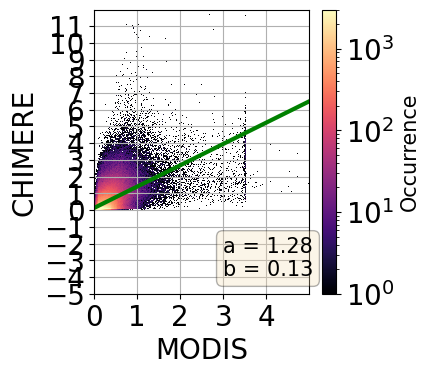

In [114]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,4)) #, sharex=True, sharey=True)
xbin = np.arange(0,5,0.02)
ybin = np.arange(-5,12,.02)

X,Y = np.meshgrid(xbin, ybin)

#ax = plt.sca(axes[i])
#plt.plot(np.zeros(8), c='k')
a = scipy.stats.binned_statistic_2d( dataset0.MODIS, dataset0.aod_550, dataset0.aod_550, statistic="count", 
                                        bins=[xbin, ybin])

print('done')

m = plt.pcolormesh(X, Y, a.statistic.T, norm=matplotlib.colors.LogNorm(), cmap='magma', vmin=1, vmax=3000)
a,b = np.polyfit(dataset0.MODIS, dataset0.aod_550, 1)
textstr = '\n'.join((

    f"a = {np.round(a,2)}",
    f"b = {np.round(b,2)}",
    )
)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
plt.text(0.6, 0.20, textstr, transform=axes.transAxes,
          verticalalignment='top', bbox=props, fontsize=fontsize-5)

plt.plot(np.arange(8), np.arange(8)*a+b, color='g',linewidth=3)

cb = plt.colorbar(m)
cb.ax.tick_params(labelsize=fontsize)
cb.set_label(label='Occurrence', fontsize=fontsize-5)

axes.set_aspect('auto')
plt.xticks(np.arange(0, xbin.max(), 1))

plt.xlim([xbin.min(), xbin.max()])

plt.ylim(ybin.min(), ybin.max())
plt.ylabel( 'CHIMERE' , fontsize=fontsize)

plt.yticks(np.arange(ybin.min(),ybin.max()), fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.grid()
plt.xlabel('MODIS', fontsize=fontsize)
#plt.suptitle('Bias (AOD difference model-MODIS)')
plt.gcf().subplots_adjust(bottom=0.17, left=0.23)
#plt.savefig("raw_all_chimere.jpg")

done


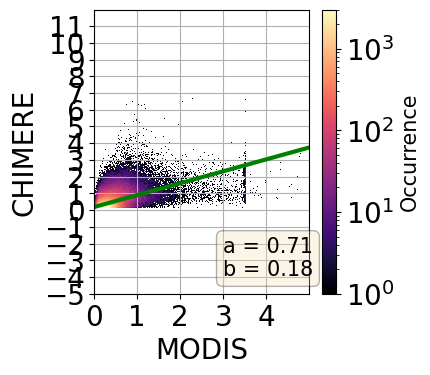

In [115]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,4)) #, sharex=True, sharey=True)
xbin = np.arange(0,5,0.02)
ybin = np.arange(-5,12,.02)

X,Y = np.meshgrid(xbin, ybin)

#ax = plt.sca(axes[i])
#plt.plot(np.zeros(8), c='k')
pred = (dataset0.aod_550+0.2)/(1+0.79)
a = scipy.stats.binned_statistic_2d( dataset0.MODIS, pred, pred, statistic="count", 
                                        bins=[xbin, ybin])

print('done')

m = plt.pcolormesh(X, Y, a.statistic.T, norm=matplotlib.colors.LogNorm(), cmap='magma', vmin=1, vmax=3000)
a,b = np.polyfit(dataset0.MODIS, pred, 1)
textstr = '\n'.join((

    f"a = {np.round(a,2)}",
    f"b = {np.round(b,2)}",
    )
)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
plt.text(0.6, 0.20, textstr, transform=axes.transAxes,
          verticalalignment='top', bbox=props, fontsize=fontsize-5)

plt.plot(np.arange(8), np.arange(8)*a+b, color='g',linewidth=3)

cb = plt.colorbar(m)
cb.ax.tick_params(labelsize=fontsize)
cb.set_label(label='Occurrence', fontsize=fontsize-5)

axes.set_aspect('auto')
plt.xticks(np.arange(0, xbin.max(), 1))

plt.xlim([xbin.min(), xbin.max()])

plt.ylim(ybin.min(), ybin.max())
plt.ylabel( 'CHIMERE' , fontsize=fontsize)

plt.yticks(np.arange(ybin.min(),ybin.max()), fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.grid()
plt.xlabel('MODIS', fontsize=fontsize)
#plt.suptitle('Bias (AOD difference model-MODIS)')
plt.gcf().subplots_adjust(bottom=0.17, left=0.23)
#plt.savefig("raw_all_chimere.jpg")

In [116]:
def plot_median_diff_map(lon, lat, data1, data2, cmap="bwr", vmin=-.40, vmax=.4):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(projection=ccrs.PlateCarree())
    im = plt.pcolormesh(lon,lat, np.nanmedian(data1-data2,axis=0), cmap=cmap, vmin=vmin, vmax=vmax)
    ax.coastlines()
    plt.title(f"AOD median bias corrected-MODIS", fontsize=fontsize)
    cb = plt.colorbar(im, fraction=0.016)
    cb.ax.tick_params(labelsize=fontsize)
    ax, txt = set_metrics_str(ax, data2, data1, fontsize=fontsize )
    plt.ylim([10, lat.max()])
    plt.xlim([lon.min(), lon.max()])

    gl = im.axes.gridlines(draw_labels=True)
    gl.top_labels, gl.ylabels_right = False, False
    gl.xlabel_style, gl.ylabel_style = {'fontsize': fontsize}, {'fontsize': fontsize}

    plt.text(10,5,f" {model_type}", fontsize=fontsize)

In [117]:
def plot_date(date, model):
    vmin=0.0 ; vmax=1.0 ; cbar_norm='lin'
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,10), subplot_kw={'projection': projection}, constrained_layout=True)

    dataset00 = input_layer_valid[input_layer_valid['date'] == date]

    prediction = model.predict(dataset00.iloc[:,2:-2]).reshape(dataset00.shape[0],1)
    scatter_plot2(axes[0], dataset00.lon, dataset00.lat, dataset00.aod_550, vmin=vmin, vmax=vmax, title="Raw CHIMERE", norm=cbar_norm)
    scatter_plot2(axes[1], dataset00.lon, dataset00.lat, prediction[:,0], vmin=vmin, vmax=vmax, title="ML-Corrected CHIMERE", norm=cbar_norm)
    scatter_plot2(axes[2], dataset00.lon, dataset00.lat, dataset00.MODIS, vmin=vmin, vmax=vmax, title=f"MODIS AQUA", norm=cbar_norm)
    
    plt.suptitle(model_type + " "+  date)

In [118]:
def scatter_plot2(ax, x, y, z, vmin=0, vmax=5, cmap="YlOrBr", title=None, norm=None, **kwargs):
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm, PowerNorm

    if norm in ['lin', None] :
        im = ax.axes.scatter(x, y, 5, z, marker='s', vmin=vmin, vmax=vmax, cmap=cmap)
    elif norm == 'sqrt' :
        im = ax.axes.scatter(x, y, 5, z, marker='s', cmap=cmap, norm=PowerNorm(vmin=vmin, vmax=vmax, gamma=0.5))
    elif norm == 'log' :
        im = ax.axes.scatter(x, y, 5, z, marker='s', cmap=cmap, norm=LogNorm(vmin=vmin, vmax=vmax))
    cbar = plt.colorbar(im, ax=ax, fraction=0.06)
    cbar.ax.tick_params(labelsize=10)
    ax.axes.set_title(title, fontsize=20)
    ax.coastlines()
    ax.set_ylim([10, y.max()])
    ax.set_xlim([x.min(), x.max()])

    gl = im.axes.gridlines(draw_labels=True)
    gl.top_labels, gl.ylabels_right = False, False
    gl.xlabel_style, gl.ylabel_style = {'fontsize': fontsize}, {'fontsize': fontsize}


In [120]:
# plots for each date
######## Choose the model : NN, XGB, RF or MLR ##########
model_types = ["MLR", "NN", "RF", "XGB"]
######################

for model_type in model_types :
    figpath=f"./figures/{config['region']}/{model_type}/{str(test_n)}/"
    output_path = f"./models/{config['region']}/{model_type}/{str(test_n)}/"
    
    if model_type == "NN" :
        model = tf.keras.models.load_model(f"{output_path}/{model_type}")
    else :
        model = pickle.load(open(f'{output_path}/{model_type}.pkl', 'rb'))
 

    #prediction[model_type] = model.predict(DTest.iloc[:,2:-2]).flatten()
    #biases[model_type] = prediction[model_type].flatten() - DTest.MODIS

    config['model_type'] = model_type
    # global figpath, which_inst, output_path
    figpath=f"./figures/{config['region']}/{model_type}/{str(test_n)}/"
    output_path = f"./models/{config['region']}/{model_type}/{str(test_n)}/"
    if not os.path.exists(figpath) : os.mkdir(figpath)
    if not os.path.exists(output_path) : os.mkdir(output_path)

    #valid_dates= count_days("20211220", "20211231", "%Y%m%d") + count_days("20210510", "20210520", "%Y%m%d")# to do save prediction file
    #dates = ["20210225"]
    log_reference, log_prediction, inference_cost = plot_dates(config['train_dates']+config['valid_dates'], model, None, do_plot=True, save_output=True)
    cost = inference_cost.sum()
    ## MODEL INFO
    f = open(f'{figpath}/config_{test_n}.yaml', 'w+')
    yaml.dump(config, f, allow_unicode=True)
    yaml.dump(
        {
            "model_type": model_type,
            "valid_dates" : valid_dates,
            "train_dates" : train_dates,
            "Daily_average_CHIMERE.raw_vs_MODIS":float(np.sum(log_reference.values)/len(valid_dates)),
            "Daily_average_testing_score":float(np.sum(log_prediction.values)/len(valid_dates)),
            "train_cost_minutes":np.float(cost),
            "Daily_average_prediction_cost_minutes":float(np.sum(inference_cost)/60/len(valid_dates)),
            "figpath":figpath,
            "output_path":output_path,
        }, f, default_flow_style=False)

do_plot:  True
save_output:  True
20210101, 20210102, 20210103, 20210104, 20210105, 20210106, 20210107, 20210108, 20210109, 20210110, 20210111, 20210112, 20210113, 20210114, 20210115, 20210116, 20210117, 20210118, 20210119, 20210120, 20210201, 20210202, 20210203, 20210204, 20210205, 20210206, 20210207, 20210208, 20210209, 20210210, 20210211, 20210212, 20210213, 20210214, 20210215, 20210216, 20210217, 20210218, 20210219, 20210220, 20210301, 20210302, 20210303, 20210304, 20210305, 20210306, 20210307, 20210308, 20210309, 20210310, 20210311, 20210312, 20210313, 20210314, 20210315, 20210316, 20210317, 20210318, 20210319, 20210320, 20210401, 20210402, 20210403, 20210404, 20210405, 20210406, 20210407, 20210408, 20210409, 20210410, 20210411, 20210412, 20210413, 20210414, 20210415, 20210416, 20210417, 20210418, 20210419, 20210420, 20210501, 20210502, 20210503, 20210504, 20210505, 20210506, 20210507, 20210508, 20210509, 20210510, 20210511, 20210512, 20210513, 20210514, 20210515, 20210516, 202105

732/732 [==============================] - 1s 2ms/step


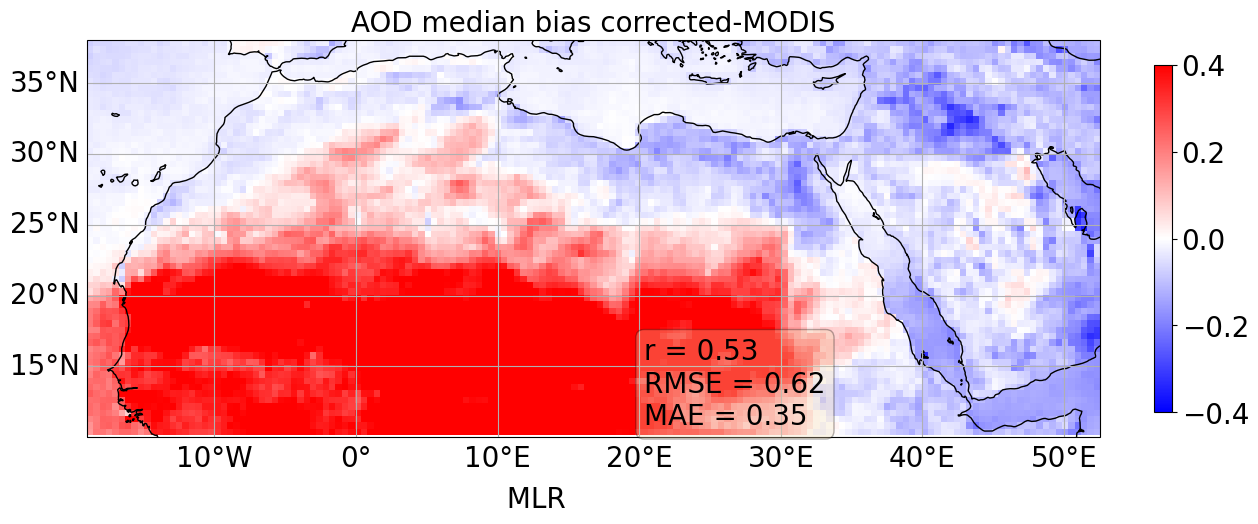

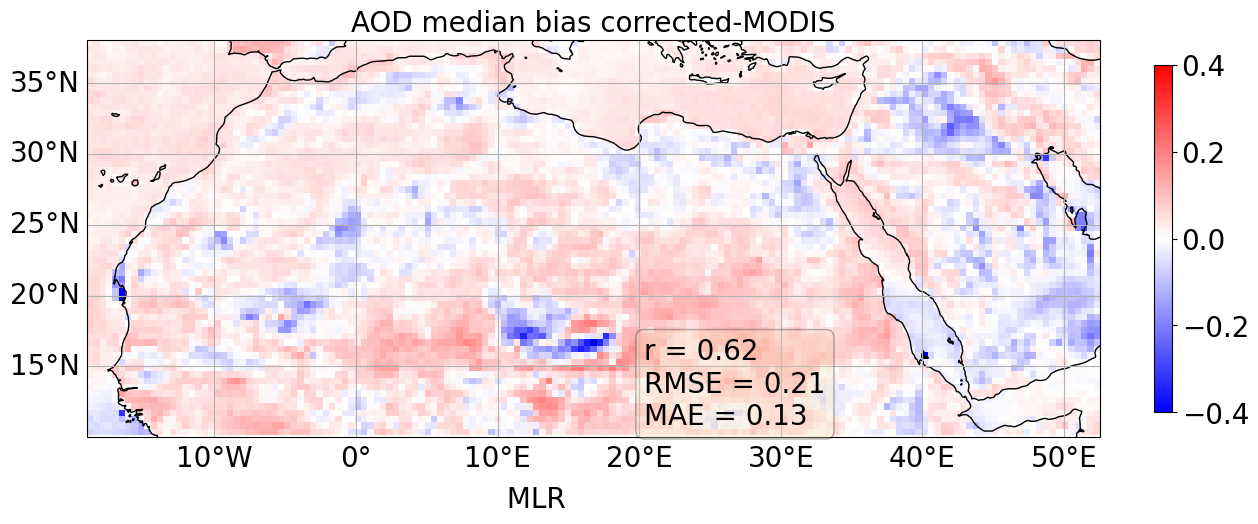

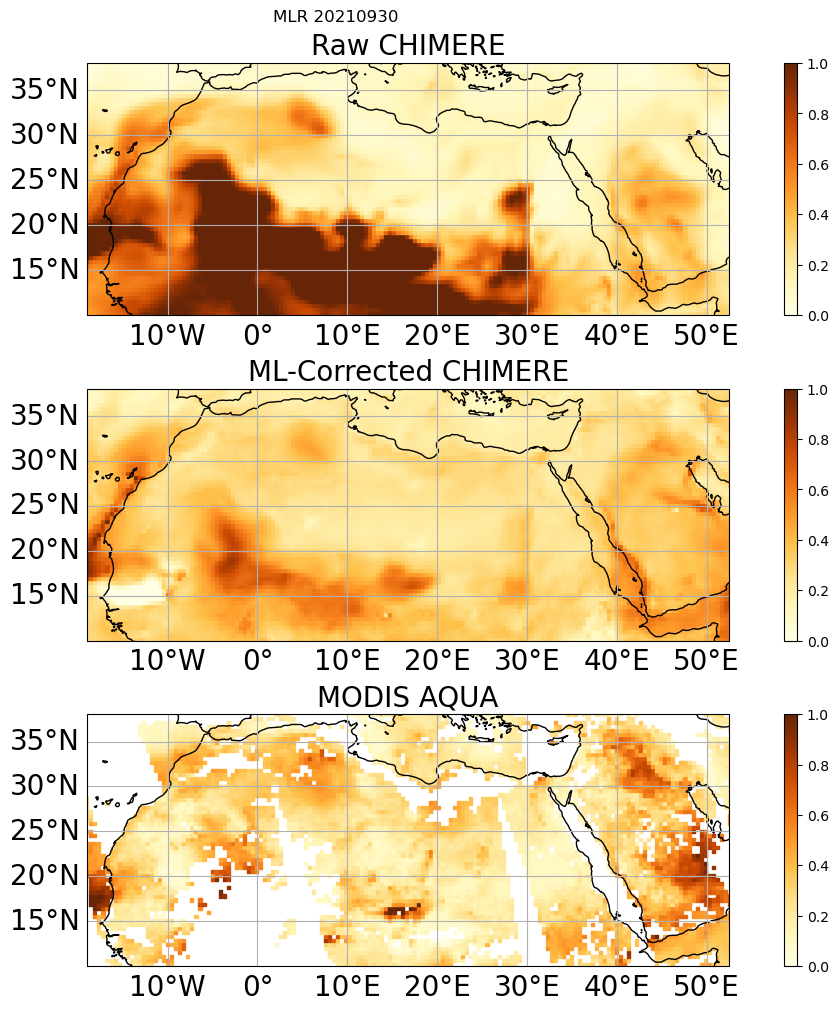

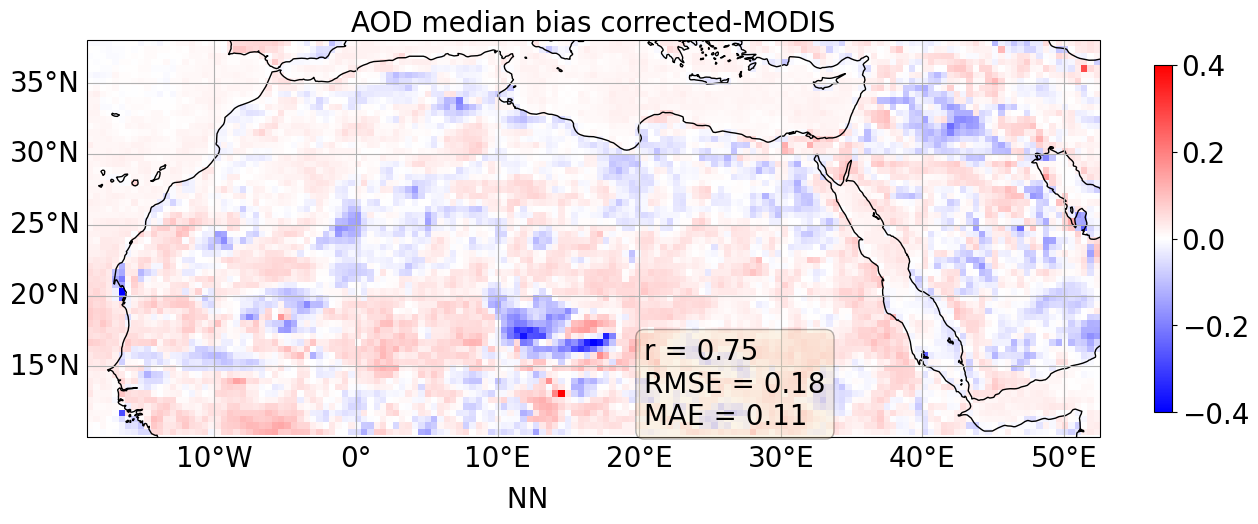

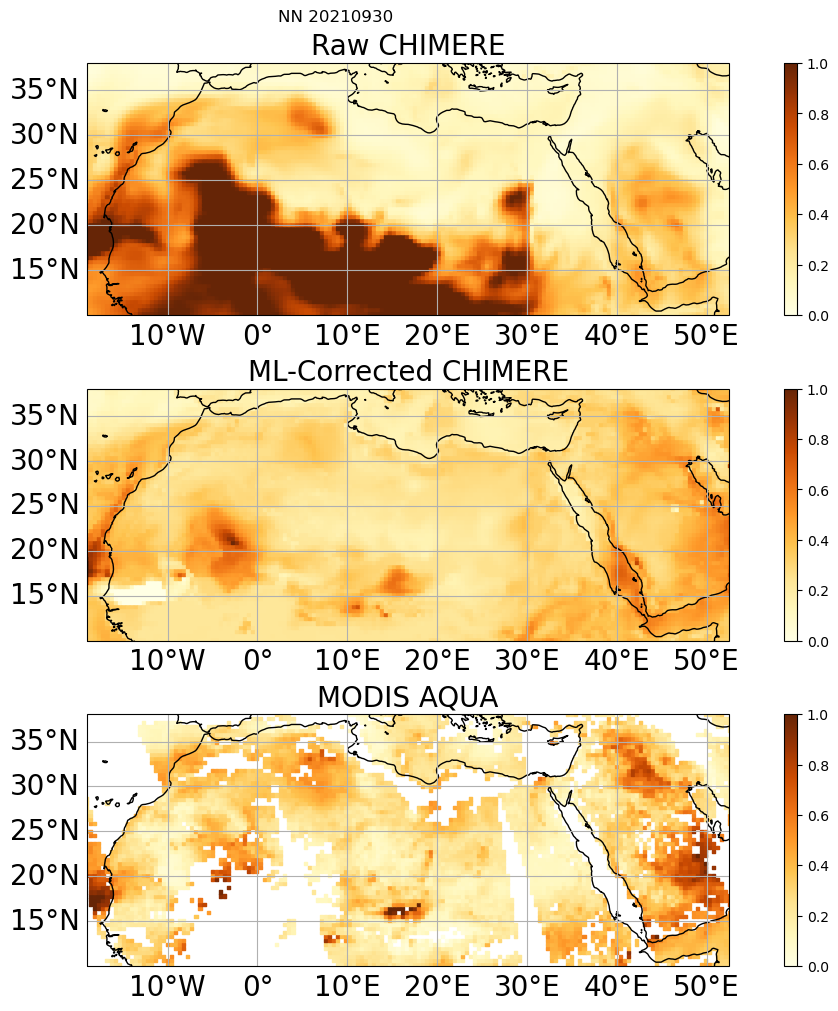

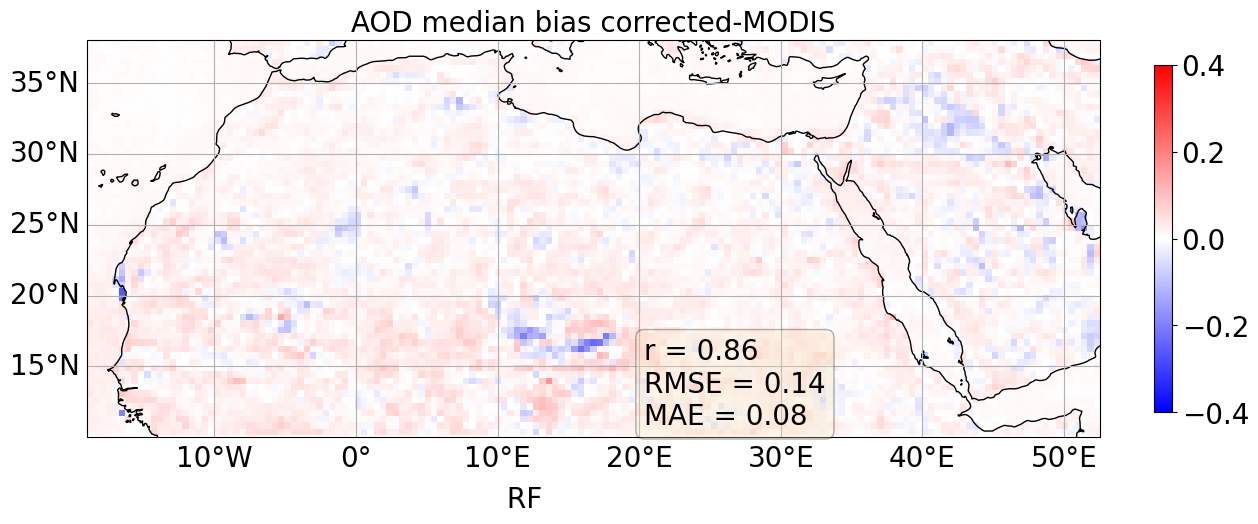

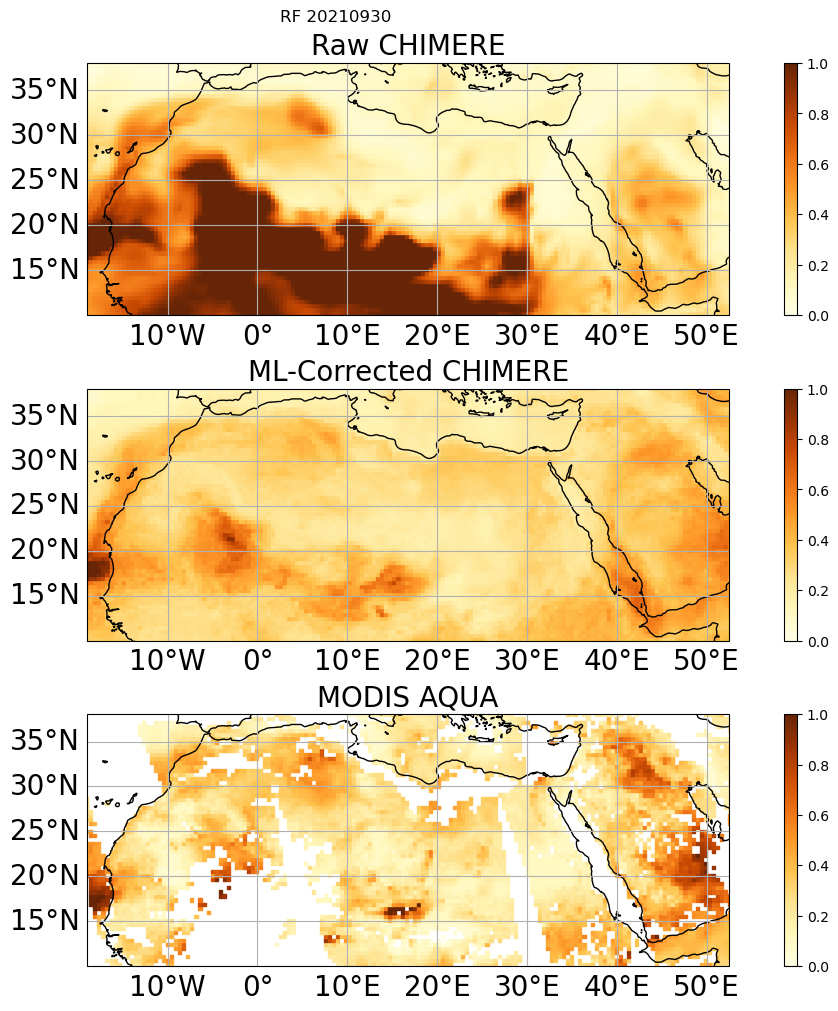

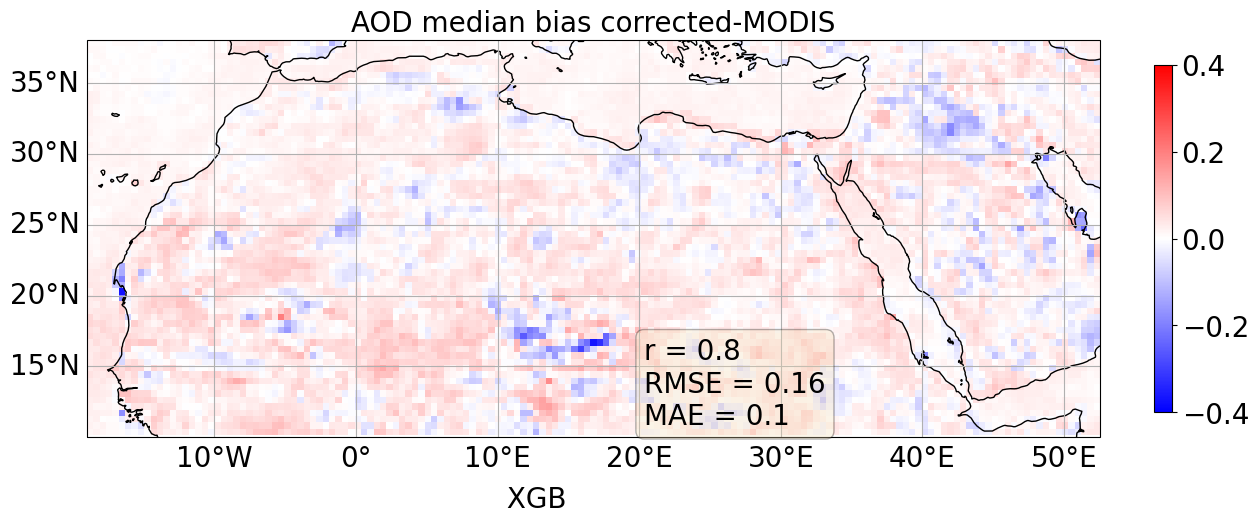

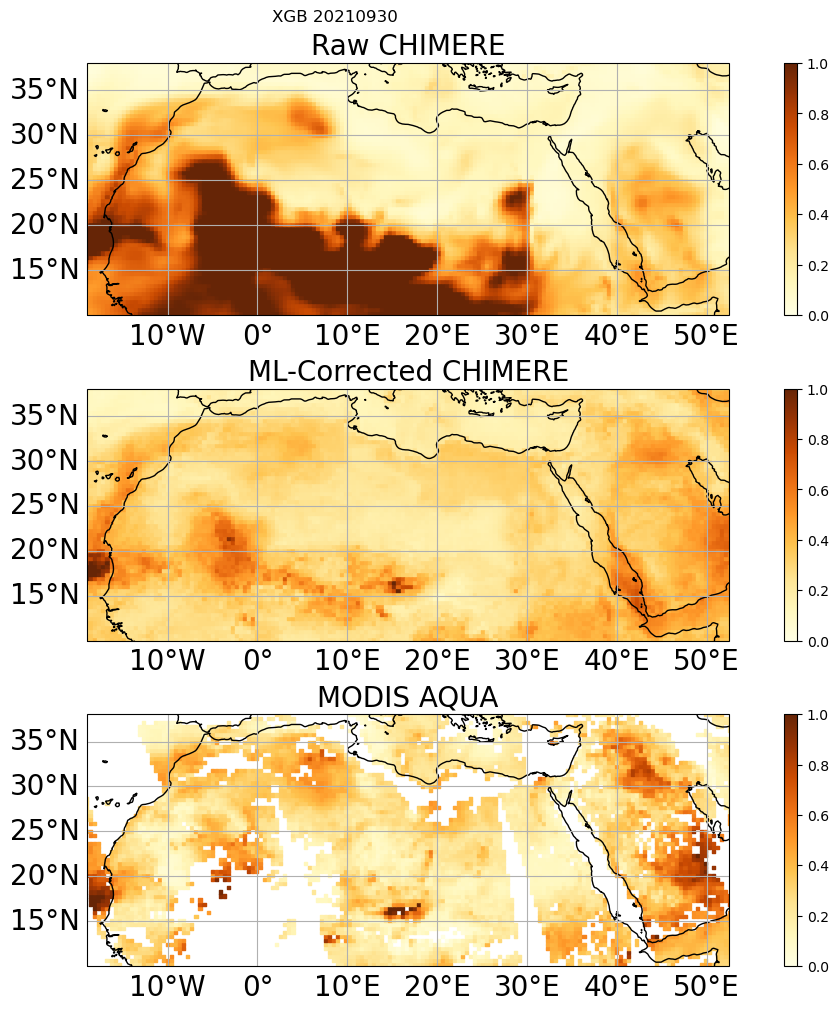

In [122]:
 # plots for each date
######## Choose the model : NN, XGB, RF or MLR ##########
model_types = ["MLR", "NN", "RF", "XGB"]
######################

for model_type in model_types :
    figpath=f"./figures/{config['region']}/{model_type}/{str(test_n)}/"
    output_path = f"./models/{config['region']}/{model_type}/{str(test_n)}/"
    
    if model_type == "NN" :
        model = tf.keras.models.load_model(f"{output_path}/{model_type}")
    else :
        model = pickle.load(open(f'{output_path}/{model_type}.pkl', 'rb'))
 
   
    a = []
    b = []
    c = []
    for date in config['train_dates']+config['valid_dates'] :
        chim_ds = xr.open_dataset(f"{output_path}/out.{date}00_01.nc")
        modis_ds = xr.open_dataset(f"./data/{config['region']}/MODIS/regrided_MODIS_AQUA_AOD_550_{date}_0.45.nc")
        o = modis_ds.lat>10 # limit the domain for north africa
        a.append(chim_ds['optdaero_550.0_corr'].data)   
        c.append(chim_ds['optdaero_550.0'].data)    
        b.append(modis_ds.AOD_550_Dark_Target_Deep_Blue_Combined.where(o).data[37:,:]) # limit the domain for north africa
        chim_corr = np.asarray(np.squeeze(a))
        modis_aod = np.asarray(b)
        chim_aod = np.asarray(np.squeeze(c))
        
    if model_type == "MLR" :
        plot_median_diff_map(chim_ds.lon, chim_ds.lat, chim_aod, modis_aod)
    
    plot_median_diff_map(chim_ds.lon, chim_ds.lat, chim_corr, modis_aod)
    
    ######## Which date ########
    date = "20210930" # from config['train_dates'] or config['valid_dates']

    # Plot the figures
    plot_date(date, model)
    

In [ ]:
#a = input_layer_valid[input_layer_valid['date'] == date]
#print(a)